In [200]:
import typing as tp
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from collections import defaultdict

In [201]:
def rsign():
    return 1 if np.random.random() < 0.5 else -1

In [202]:
#prices
prices = {}

In [203]:
class RandomFeed:
    def __init__(self,
                 vol,
                 px: float,
                 #mid,
                 window: int,
                 dist_args=None,
                 distribution=np.random.normal,
                 **kwargs):
        '''Args:
            vol: volatility
            px: beginning px for history
            mid: the market id
            window: the length of the windowSize for TWAP
            dist_args: args that go into the distribution;
                for a gaussian, the center and the std
            
        '''

        self.distribution = distribution
        self.vol = vol
        self.px = px
        #self.id = mid
        self.window = window
        self.dist_args = (0,1)
        self.block_times = [0]
        self.cumul_px = [px]
        self.prices = [px]
        self.twaps = []
        self.returns = []
        self.kwargs = kwargs

    @staticmethod
    def block_time():
        # time it took to mine ith block in seconds
        return 13.23 + rsign()*np.random.rand()
    
    def get_returns(self, arr:np.array):
        # to get returns of any series
        arr_init = np.roll(arr, 1)
        returns = (arr/arr_init) - 1
        return returns[1:] #delete spurious return
    
    def get_twap(self, i:int, window=-1):
        if window < 0:
            window = self.window
        #ith block , window is number of blocks we average over
        if i < self.window:
            return
        else:
            return (self.cumul_px[i] - self.cumul_px[i - window])/window
    
    def update(self, modify_vol=False, **kwargs):      
        #WARNING!  an in-place method that mutates the class                                             
                                                     
        delta = self.get_delta(**kwargs)
        self.px += (self.vol * delta) 
        
        if self.px <= 0:
             raise Exception('the market price went to zero')
               
        block_time = self.block_time()
        
        #here we populate all the dynamic lists and 
        self.prices.append(self.px)
        self.cumul_px.append(self.cumul_px[-1] + block_time*self.px)
        self.block_times.append(block_time)
        self.returns.append(self.prices[-1]/self.prices[-2] - 1)
        
        if modify_vol:
            self.vol = kwargs['vol']

    def get_delta(self, **kwargs):
        #if the % moves are small relative to self.px, then the trader results will be unrealistic. 
        #px needs to move as a % of the price level to reflect compounding
        if kwargs.get('pct', False):
            standard_dev = self.vol*self.px/100   
            center = standard_dev/10  #self.dist_args[0]
            args = (center, standard_dev)
            delta = self.distribution(*args)  # if self.dist_args else self.distribution()    
        else:
            delta = self.distribution(*self.dist_args) if self.dist_args else self.distribution()
        delta = self.distribution(*self.dist_args) if self.dist_args else self.distribution()
        return delta  
    


In [204]:
np.random.seed(1)
markets = {
    0:RandomFeed(vol=1, px = 1e3, window=50, dist_args=(0, 1)),
    #1:RandomFeed(vol=1, px = 1e3, window=150, dist_args=(0, 1)),
    #2:RandomFeed(vol=1, px = 1e3, window=300, dist_args=(0, 1)),
    #3:RandomFeed(vol=1, px = 1e3, window=150, dist_args=(0, 1)),
    }
m = markets[0]
for _ in range(10000):
    m.update()

In [205]:
### test your get_returns method
rets = m.get_returns(m.prices)
all(map(np.isclose, m.returns, rets))

True

In [206]:
twaps = np.array([m.get_twap(i) for i in range(50,10000)])

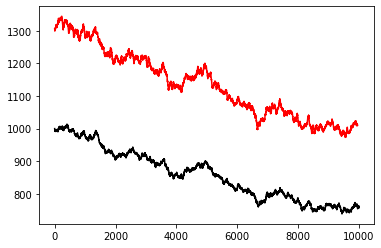

In [207]:
plt.plot(m.prices, c='k')
plt.plot(twaps/10, c='r')

# The TWAP and the spot price are very different numbers , what about the returns?

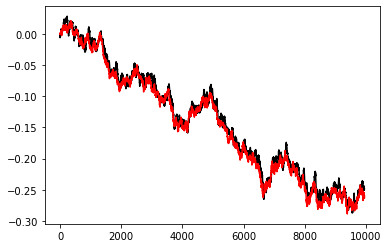

In [208]:
twap_crets = np.cumsum(m.get_returns(twaps))
crets = np.cumsum(m.returns[m.window:])

plt.plot(twap_crets, c='k')
plt.plot(crets, c='r')

# Zoom in

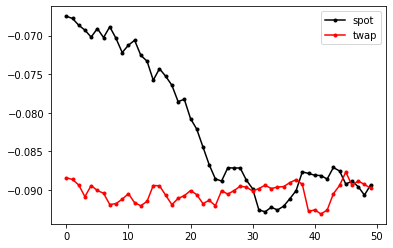

In [209]:
plt.plot(twap_crets[3000:3050], marker='.', c='k', label='spot')
plt.plot(crets[3000:3050], marker='.', c='r', label='twap')
plt.legend()

# Because of the averaging, there are arbitrage opportunities between spot and TWAP prices. How extreme are these opportunities? 

In [210]:
#on a block-by-block basis
twap_rets = m.get_returns(twaps)
ret_diff = m.returns[51:] - twap_rets
print(f'max + return difference: +{max(ret_diff)},\nmax - return difference: {min(ret_diff)}')
print('\n')
#buy and hold, waiting for divergence to get out
cret_diff = crets[1:] - twap_crets
print(f'max + cumulative return difference: +{max(cret_diff)},\nmax - cumulative return difference: {min(cret_diff)}')

max + return difference: +0.006291579746074194,
max - return difference: -0.00592785402338647


max + cumulative return difference: +0.02102752765466276,
max - cumulative return difference: -0.03517420471279564


# How does the TWAP change as we change the `windowSize`?

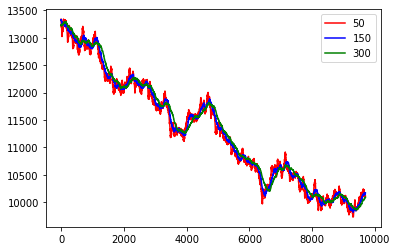

In [211]:
twaps = {}
for i in [50,150,300]: #different window sizes, 300 is approx 1 hr
    twaps[i] = np.array([m.get_twap(j, window=i) for j in range(i,10000)])
#plt.plot(m.prices[300:], c='k')
plt.plot(twaps[50][250:], c='r', label='50')
plt.plot(twaps[150][150:], c='b',label='150')
plt.plot(twaps[300], c='g',label='300')
plt.legend()

In [212]:
#they have different lengths,  be careful
list(map(len, twaps.values()))

[9950, 9850, 9700]

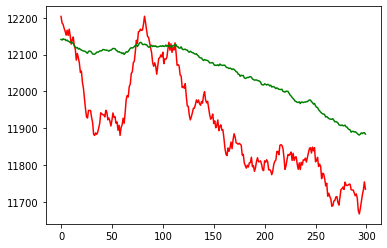

In [213]:
plt.plot(twaps[50][3000:3300], c='r', label='50')
plt.plot(twaps[300][2750:3050], c='g',label='300') #need to offset by 250 to align

In [214]:
twap_crets = np.cumsum(m.get_returns(twaps[300]))
crets = np.cumsum(m.returns[301:])

assert len(twap_crets) == len(crets)

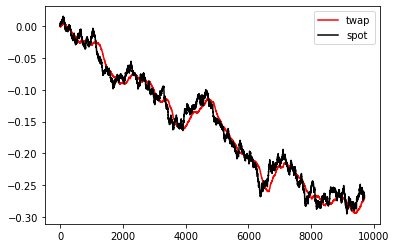

In [215]:
plt.plot(twap_crets, c='r', label='twap')
plt.plot(crets, c='k', label='spot')
plt.legend()

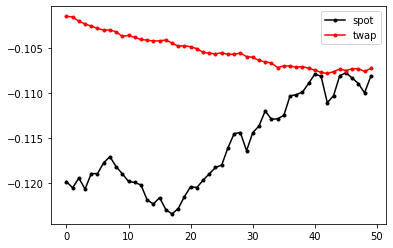

In [216]:
plt.plot(crets[3000:3050], marker='.', c='k', label='spot')
plt.plot(twap_crets[3000:3050], marker='.', c='r', label='twap')
plt.legend()

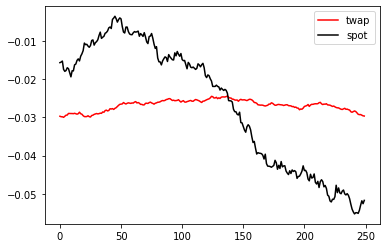

In [217]:
plt.plot(twap_crets[1000:1250], c='r', label='twap')
plt.plot(crets[1000:1250], c='k', label='spot')
plt.legend()

In [218]:
#on a block-by-block basis
twap_rets = m.get_returns(twaps[300])
ret_diff = m.returns[301:] - twap_rets
print(f'max + return difference: +{max(ret_diff)},\nmax - return difference: {min(ret_diff)}')
print('\n')
#buy and hold, waiting for divergence to get out
cret_diff = crets - twap_crets
print(f'max + cumulative return difference: +{max(cret_diff)},\nmax - cumulative return difference: {min(cret_diff)}')

max + return difference: +0.004872836628034949,
max - return difference: -0.004636973513953535


max + cumulative return difference: +0.0453587122216943,
max - cumulative return difference: -0.038057960141136826


# The main concern is that the TWAP can be predicted. Let's see if this is the case

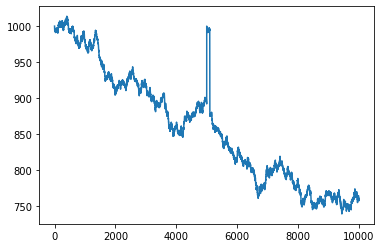

In [219]:
prices_w_shock = m.prices.copy()
shock_block = 5000
for i in range(100):
    prices_w_shock[shock_block + i] = prices_w_shock[i]  
plt.plot(prices_w_shock)

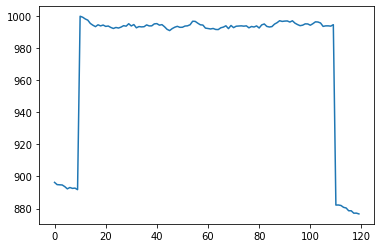

In [220]:
plt.plot(prices_w_shock[shock_block-10:shock_block+110])

In [221]:
import copy
Shock = copy.deepcopy(m)
window = 300
Shock.prices = prices_w_shock
Shock.returns = Shock.get_returns(np.array(prices_w_shock))
Shock.cumul_px = np.cumsum(list(map(np.multiply, Shock.block_times, Shock.prices)))
Shock_twaps = np.array([Shock.get_twap(j, window=window) for j in range(window,10000)])

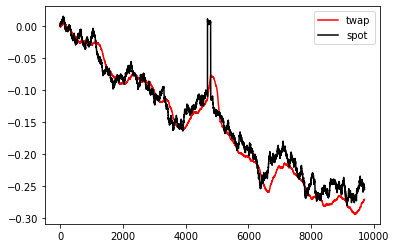

In [222]:
twap_crets = np.cumsum(Shock.get_returns(Shock_twaps))
crets = np.cumsum(Shock.returns[window:])

plt.plot(twap_crets, c='r', label='twap')
plt.plot(crets, c='k', label='spot')
plt.legend()

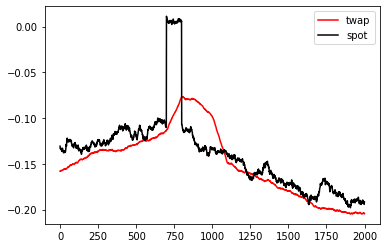

In [223]:
plt.plot(twap_crets[4000:6000], c='r', label='twap')
plt.plot(crets[4000:6000], c='k', label='spot')
plt.legend()

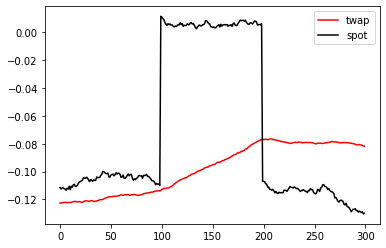

In [224]:
shock_time = shock_block-window

plt.plot(twap_crets[shock_time-100:shock_time+100+100], c='r', label='twap')
plt.plot(crets[shock_time-100:shock_time+100+100], c='k', label='spot')
plt.legend()

In [225]:
(twap_crets[shock_time+100] -twap_crets[shock_time]) 

0.035857625595267506

# A 10% shock occuring in 10 blocks (a couple minutes) and lasting for 100 blocks (20 minutes) leads to about 3.5% of free profit for anyone paying attention. What is worse is that, because of the time delay, the price does not immediately revert when the spot price has an opposite shock. 

In [226]:
FILENAME = "mc-1627502207.7848918-filtered"

# OK, let's look at monte carlo sims. Data generated for 3 months every block assuming 15s blocks. Fit used to generate sample points assumes Levy process, with log stable increments

# Fit based on ETH/USDC 120d worth of data w 10min candles. Sim points generated every 15s

In [227]:
df = pd.read_csv(f"csv/{FILENAME}.csv")
df

,Unnamed: 0,sim-0,sim-1,sim-3,sim-5,sim-17,sim-22,sim-36,sim-38,sim-39,...,sim-72,sim-76,sim-77,sim-83,sim-89,sim-91,sim-93,sim-94,sim-97,sim-98
0,0,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,...,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000
1,1,2257.279939,2239.635583,2239.409648,2239.094328,2239.760435,2239.796242,2239.750602,2240.430580,2239.417710,...,2239.938046,2239.420321,2239.679258,2239.517582,2239.318892,2239.339680,2239.529045,2239.679989,2239.809589,2239.484089
2,2,2256.965792,2239.605222,2239.267675,2239.050133,2239.888765,2239.791825,2239.242870,2240.002148,2239.213937,...,2240.022457,2239.233272,2239.691800,2239.240016,2239.302512,2239.621831,2239.378811,2239.273305,2238.563352,2239.233271
3,3,2256.706637,2239.333992,2239.432515,2237.433049,2238.922973,2240.031993,2239.386863,2239.706611,2239.122091,...,2240.235425,2239.673608,2238.520212,2239.447428,2239.764958,2239.793826,2239.381085,2238.744148,2238.784563,2238.896240
4,4,2257.705008,2240.500107,2239.547802,2237.308286,2239.140346,2239.931609,2240.015802,2239.730837,2238.947734,...,2239.934672,2240.046417,2238.285628,2239.886464,2239.934240,2239.995334,2238.865671,2238.706849,2238.663632,2240.015180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518396,518396,4174.489419,906.705980,6157.105814,367.560558,195.905552,3314.593940,403.041701,8906.875086,3085.968418,...,1690.435861,19.376452,2584.766372,2181.585887,962.129536,3032.097362,1067.191654,9180.367870,2834.303017,3741.589612
518397,518397,4173.715783,906.519268,6157.561302,367.610972,195.885391,3313.934908,402.951137,8906.405720,3086.108355,...,1687.754736,19.378207,2584.720787,2181.946576,962.098430,3031.955090,1066.845260,9180.012436,2833.928540,3740.045180
518398,518398,4174.649734,906.736253,6158.126843,367.681718,195.913516,3314.246217,402.456515,8907.964768,3085.927212,...,1687.885219,19.379282,2583.785731,2183.254626,962.206680,3031.872773,1067.057273,9180.881484,2833.470085,3740.032175
518399,518399,4174.341345,906.878986,6158.762760,367.669851,196.010765,3313.808611,402.236807,8907.538585,3085.025612,...,1687.746931,19.377603,2583.822224,2183.000443,962.354298,3032.868904,1067.320077,9180.609562,2833.829332,3740.222330


# Start out with something relatively tame like sim 53. Calculate the TWAP over averaging times of 30m, 1h, 8h

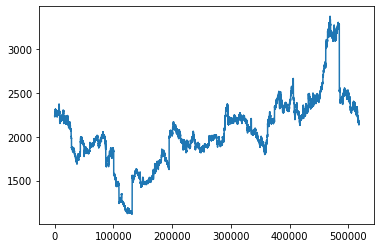

In [228]:
sim_filter = [0, 1, 3, 5, 17, 22, 36, 38, 39, 42, 43, 47, 49, 53, 55, 56, 63, 64, 65, 69, 71, 72, 76, 77, 83, 89, 91, 93, 94, 97, 98]
df['sim-53'].plot()

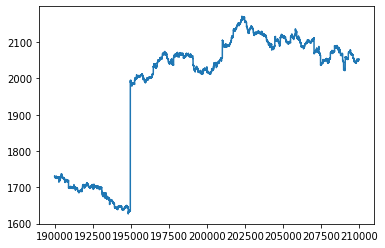

In [229]:
df['sim-53'][190000:210000].plot()

In [230]:
print(df.columns)
df = df.rename(columns={'Unnamed: 0': 'block'})
df

Index(['Unnamed: 0', 'sim-0', 'sim-1', 'sim-3', 'sim-5', 'sim-17', 'sim-22',
       'sim-36', 'sim-38', 'sim-39', 'sim-42', 'sim-43', 'sim-47', 'sim-49',
       'sim-53', 'sim-55', 'sim-56', 'sim-63', 'sim-64', 'sim-65', 'sim-69',
       'sim-71', 'sim-72', 'sim-76', 'sim-77', 'sim-83', 'sim-89', 'sim-91',
       'sim-93', 'sim-94', 'sim-97', 'sim-98'],
      dtype='object')


,block,sim-0,sim-1,sim-3,sim-5,sim-17,sim-22,sim-36,sim-38,sim-39,...,sim-72,sim-76,sim-77,sim-83,sim-89,sim-91,sim-93,sim-94,sim-97,sim-98
0,0,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,...,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000
1,1,2257.279939,2239.635583,2239.409648,2239.094328,2239.760435,2239.796242,2239.750602,2240.430580,2239.417710,...,2239.938046,2239.420321,2239.679258,2239.517582,2239.318892,2239.339680,2239.529045,2239.679989,2239.809589,2239.484089
2,2,2256.965792,2239.605222,2239.267675,2239.050133,2239.888765,2239.791825,2239.242870,2240.002148,2239.213937,...,2240.022457,2239.233272,2239.691800,2239.240016,2239.302512,2239.621831,2239.378811,2239.273305,2238.563352,2239.233271
3,3,2256.706637,2239.333992,2239.432515,2237.433049,2238.922973,2240.031993,2239.386863,2239.706611,2239.122091,...,2240.235425,2239.673608,2238.520212,2239.447428,2239.764958,2239.793826,2239.381085,2238.744148,2238.784563,2238.896240
4,4,2257.705008,2240.500107,2239.547802,2237.308286,2239.140346,2239.931609,2240.015802,2239.730837,2238.947734,...,2239.934672,2240.046417,2238.285628,2239.886464,2239.934240,2239.995334,2238.865671,2238.706849,2238.663632,2240.015180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518396,518396,4174.489419,906.705980,6157.105814,367.560558,195.905552,3314.593940,403.041701,8906.875086,3085.968418,...,1690.435861,19.376452,2584.766372,2181.585887,962.129536,3032.097362,1067.191654,9180.367870,2834.303017,3741.589612
518397,518397,4173.715783,906.519268,6157.561302,367.610972,195.885391,3313.934908,402.951137,8906.405720,3086.108355,...,1687.754736,19.378207,2584.720787,2181.946576,962.098430,3031.955090,1066.845260,9180.012436,2833.928540,3740.045180
518398,518398,4174.649734,906.736253,6158.126843,367.681718,195.913516,3314.246217,402.456515,8907.964768,3085.927212,...,1687.885219,19.379282,2583.785731,2183.254626,962.206680,3031.872773,1067.057273,9180.881484,2833.470085,3740.032175
518399,518399,4174.341345,906.878986,6158.762760,367.669851,196.010765,3313.808611,402.236807,8907.538585,3085.025612,...,1687.746931,19.377603,2583.822224,2183.000443,962.354298,3032.868904,1067.320077,9180.609562,2833.829332,3740.222330


In [231]:
prices = df['sim-53']
prices

0         2239.570000
1         2239.667466
2         2240.655710
3         2238.304510
4         2239.584944
             ...     
518396    2179.164884
518397    2180.037396
518398    2179.911487
518399    2179.797703
518400    2180.034550
Name: sim-53, Length: 518401, dtype: float64

In [232]:
# This is number of blocks into the future
blocks = df['block']
blocks

0              0
1              1
2              2
3              3
4              4
           ...  
518396    518396
518397    518397
518398    518398
518399    518399
518400    518400
Name: block, Length: 518401, dtype: int64

In [233]:
# 1h price changes
# Use the geometric mean to be consistent with uni v3: https://uniswap.org/whitepaper-v3.pdf
# Compare with arithmetic mean as well ...
window_1h = 4*60

dp_1h_arith = prices.rolling(window=window_1h).sum()
dt_1h = blocks.rolling(window=window_1h).apply(lambda w: w[-1]-w[0]+1, raw=True)
dt_1h

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
518396    240.0
518397    240.0
518398    240.0
518399    240.0
518400    240.0
Name: block, Length: 518401, dtype: float64

In [234]:
twap_1h_arith = (dp_1h_arith / dt_1h)
twap_1h_arith = twap_1h_arith[~twap_1h_arith.isnull()]
twap_1h_arith

239       2238.890016
240       2238.884368
241       2238.879010
242       2238.868694
243       2238.867567
             ...     
518396    2161.297954
518397    2161.377192
518398    2161.456294
518399    2161.531477
518400    2161.606372
Length: 518162, dtype: float64

In [235]:
# Geometric mean is a bit more annoying given inf in pd. Do it all through rolling apply knowing dt is always 240 blocks in this sim
twap_1h_geo = prices.rolling(window=window_1h).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_1h), raw=True)
twap_1h_geo = twap_1h_geo[~twap_1h_geo.isnull()]
twap_1h_geo

239       2238.888859
240       2238.883210
241       2238.877853
242       2238.867539
243       2238.866412
             ...     
518396    2161.265451
518397    2161.344353
518398    2161.423125
518399    2161.497987
518400    2161.572553
Name: sim-53, Length: 518162, dtype: float64

In [236]:
prices_filtered = prices[239:]
prices_filtered

239       2237.622746
240       2238.214274
241       2238.381596
242       2238.179852
243       2238.034022
             ...     
518396    2179.164884
518397    2180.037396
518398    2179.911487
518399    2179.797703
518400    2180.034550
Name: sim-53, Length: 518162, dtype: float64

# Compare what TWAP arithmetic, geometric vs spot look like near a spot jump

In [237]:
prices_filtered[194710:194760]

194949    1637.445701
194950    1637.247430
194951    1637.421921
194952    1636.634825
194953    1636.663335
194954    1636.650276
194955    1636.749059
194956    1635.894670
194957    1635.856624
194958    1635.430328
194959    1635.315208
194960    1634.585924
194961    1633.767173
194962    1633.765022
194963    1633.796563
194964    1634.757899
194965    1634.983232
194966    1635.193521
194967    1634.694454
194968    1634.704682
194969    1634.698519
194970    1634.724512
194971    1994.326618
194972    1990.126144
194973    1989.787615
194974    1989.552402
194975    1988.576333
194976    1988.713652
194977    1988.674788
194978    1988.696268
194979    1988.999884
194980    1989.234997
194981    1989.008158
194982    1989.095215
194983    1989.152632
194984    1989.476140
194985    1989.942940
194986    1989.624463
194987    1990.070219
194988    1989.968677
194989    1989.188977
194990    1989.960421
194991    1989.434537
194992    1989.031456
194993    1989.041240
194994    

# Notice, there's a 360 USD (22%) jump over 1 block, which is unrealistic (larger tails in log stable than in reality). Should likely use 10min data to get more realistic sense, but this is good to stress test. Will come back to using 10min data later in notebook.

In [238]:
twap_1h_arith[194710:194760]

194949    1639.848098
194950    1639.799708
194951    1639.749869
194952    1639.698266
194953    1639.645923
194954    1639.596900
194955    1639.547413
194956    1639.493362
194957    1639.437896
194958    1639.380414
194959    1639.322263
194960    1639.266878
194961    1639.208955
194962    1639.145160
194963    1639.081097
194964    1639.019885
194965    1638.955612
194966    1638.893635
194967    1638.829073
194968    1638.765166
194969    1638.699826
194970    1638.635522
194971    1640.072081
194972    1641.493586
194973    1642.917156
194974    1644.339188
194975    1645.756711
194976    1647.174849
194977    1648.592427
194978    1650.007003
194979    1651.423193
194980    1652.839931
194981    1654.260080
194982    1655.681324
194983    1657.106640
194984    1658.533988
194985    1659.963602
194986    1661.390022
194987    1662.819405
194988    1664.247851
194989    1665.675496
194990    1667.107350
194991    1668.536743
194992    1669.964004
194993    1671.391759
194994    

In [239]:
print(twap_1h_geo[194710:194760])
print(twap_1h_geo[194710:195000])

194949    1639.835271
194950    1639.786976
194951    1639.737247
194952    1639.685742
194953    1639.633503
194954    1639.584567
194955    1639.535174
194956    1639.481218
194957    1639.425854
194958    1639.368475
194959    1639.310428
194960    1639.255109
194961    1639.197238
194962    1639.133530
194963    1639.069560
194964    1639.008461
194965    1638.944333
194966    1638.882496
194967    1638.818074
194968    1638.754307
194969    1638.689118
194970    1638.624962
194971    1639.921370
194972    1641.206823
194973    1642.495581
194974    1643.783985
194975    1645.069594
194976    1646.356726
194977    1647.644333
194978    1648.929929
194979    1650.217927
194980    1651.507312
194981    1652.801287
194982    1654.097312
194983    1655.398404
194984    1656.702329
194985    1658.009225
194986    1659.314165
194987    1660.622797
194988    1661.931589
194989    1663.241168
194990    1664.555474
194991    1665.868711
194992    1667.181119
194993    1668.495054
194994    

# Timelag in the TWAP vs spot is clear. Now let's plot and add in bid/ask spread.

## Bid/ask spread based off last point added to accumluator + 99% confidence constant E_B. Limits probability of profitable trade 1h into future once TWAP catches up to spot

## dB = P_{t-1} * e^{ (1/T) * [X_t + E_B ] } - TWAP_{t}

## where T is averaging window for the TWAP.

## Q: Do we want to min the exponent so it's never less than TWAP_{t} for B nor greater than TWAP_{t} for ask?

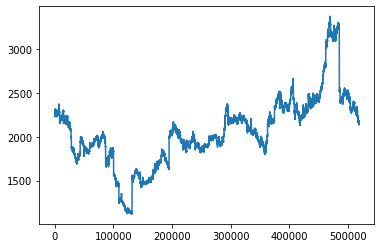

In [240]:
prices_filtered.plot()

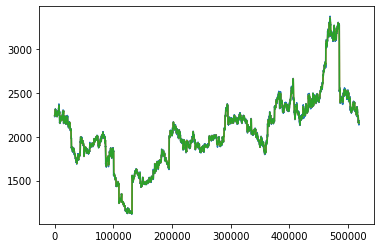

In [241]:
ax = prices_filtered.plot()
twap_1h_geo.plot(ax=ax)
twap_1h_arith.plot(ax=ax)

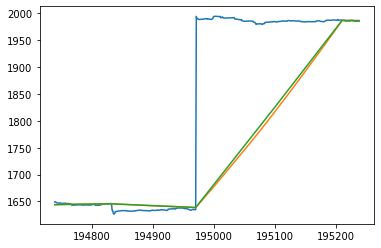

In [242]:
ax = prices_filtered[194500:195000].plot()
twap_1h_geo[194500:195000].plot(ax=ax)
twap_1h_arith[194500:195000].plot(ax=ax)

# Playing catch up over 240 blocks after spot jump with TWAP

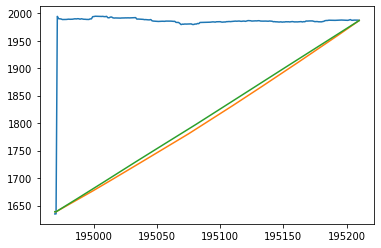

In [243]:
ax = prices_filtered[194730:194972].plot()
twap_1h_geo[194730:194972].plot(ax=ax)
twap_1h_arith[194730:194972].plot(ax=ax)

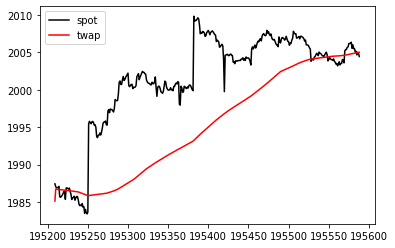

In [244]:
ax = prices_filtered[194970:195350].plot(c='k', label='spot')
twap_1h_geo[194970:195350].plot(ax=ax, c='r', label='twap')
ax.legend()
ax.get_figure().savefig('png/sim_twap_lag.png')

In [245]:
print('spot at jump', prices_filtered[195010:195015])
print('twap at jump', twap_1h_geo[195010:195015])
print('spot 1h after jump', prices_filtered[195010+window_1h:195015+window_1h])
print('twap 1h after jump', twap_1h_geo[195010+window_1h:195015+window_1h])

spot at jump 195249    1983.410406
195250    1983.653382
195251    1995.482323
195252    1995.783461
195253    1995.607815
Name: sim-53, dtype: float64
twap at jump 195249    1985.893596
195250    1985.848948
195251    1985.863894
195252    1985.880668
195253    1985.891454
Name: sim-53, dtype: float64
spot 1h after jump 195489    2006.375940
195490    2006.265032
195491    2006.807187
195492    2006.988585
195493    2006.943630
Name: sim-53, dtype: float64
twap 1h after jump 195489    2002.341845
195490    2002.436412
195491    2002.483630
195492    2002.530344
195493    2002.577607
Name: sim-53, dtype: float64


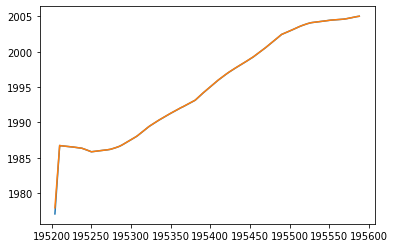

In [246]:
ax = twap_1h_geo[194965:195350].plot()
twap_1h_arith[194965:195350].plot(ax=ax)

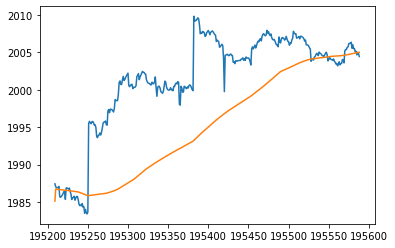

In [247]:
# Focus on only 240 block timespan to check catch up
ax = prices_filtered[194970:195350].plot()
twap_1h_geo[194970:195350].plot(ax=ax)

In [248]:
print(prices_filtered[194970:195025])
print(twap_1h_geo[194970:195025])

195209    1987.427329
195210    1987.061184
195211    1986.902750
195212    1986.925091
195213    1986.913355
195214    1987.084465
195215    1985.698910
195216    1985.637224
195217    1985.750202
195218    1985.887878
195219    1986.114328
195220    1986.326442
195221    1986.469949
195222    1985.365886
195223    1986.880659
195224    1986.879325
195225    1986.832025
195226    1986.723653
195227    1986.858808
195228    1986.403009
195229    1986.030006
195230    1985.337765
195231    1985.569617
195232    1985.600455
195233    1985.773879
195234    1985.244777
195235    1985.563615
195236    1985.743142
195237    1985.738180
195238    1985.327255
195239    1984.702402
195240    1984.520949
195241    1984.596926
195242    1984.485857
195243    1984.791574
195244    1984.313530
195245    1984.401755
195246    1983.497403
195247    1984.019650
195248    1983.589147
195249    1983.410406
195250    1983.653382
195251    1995.482323
195252    1995.783461
195253    1995.607815
195254    

In [249]:
# Jump in spot occurs from 195250 to 195251
print(np.log(1995.482323/1983.653382))
np.exp(0.005945500089474321/240)*np.exp(np.log(1.007))

# geometric TWAP value at 19250 is 1985.848948; 19251 is 1985.863894
1985.863894*np.exp(0.005945500089474321/240)*np.exp(np.log(1.007))

# Perfect. It's above the jump

0.005945500089474321


1999.8144818826183

In [250]:
# We could make it way more intense by instead using the current spot price as the top of the buy band ...
print(1995.482323*np.exp(0.005945500089474321/240)*np.exp(np.log(1.007)))

# Yea then it's way higher.

2009.50047983307


In [251]:
# Check that we catch up at 195251+240 = 195491
print(prices_filtered[194970:195025])
print(twap_1h_geo[195210:195265])

195209    1987.427329
195210    1987.061184
195211    1986.902750
195212    1986.925091
195213    1986.913355
195214    1987.084465
195215    1985.698910
195216    1985.637224
195217    1985.750202
195218    1985.887878
195219    1986.114328
195220    1986.326442
195221    1986.469949
195222    1985.365886
195223    1986.880659
195224    1986.879325
195225    1986.832025
195226    1986.723653
195227    1986.858808
195228    1986.403009
195229    1986.030006
195230    1985.337765
195231    1985.569617
195232    1985.600455
195233    1985.773879
195234    1985.244777
195235    1985.563615
195236    1985.743142
195237    1985.738180
195238    1985.327255
195239    1984.702402
195240    1984.520949
195241    1984.596926
195242    1984.485857
195243    1984.791574
195244    1984.313530
195245    1984.401755
195246    1983.497403
195247    1984.019650
195248    1983.589147
195249    1983.410406
195250    1983.653382
195251    1995.482323
195252    1995.783461
195253    1995.607815
195254    

In [252]:
# 195491    2002.483630
# Geometric twap is at 2002.483630 after an hour. Bid up with 0.7% envelope had it at 1999.8144818826183.
# So trader can profit ... 0.1334% => which is 0 after fees [x]
(2002.483630-1999.8144818826183)/1999.8144818826183

0.001334697864008307

# Ok! Bid/ask envelope seems potentially promising. Let's see it live in action. Add in envelope values to 1h TWAP for bid/ask. Don't have it adjust only on side with jump (try this later)

In [253]:
# Spread that makes unwinding over the next hour during TWAP catchup unprofitable ~99% of time
# SPREAD_X is e^X exponent component
SPREAD_X = np.log(1.00731)
SPREAD_X

0.007283411446258746

In [254]:
print('Long side price adjust up (Ask):', np.exp(SPREAD_X))
print('Short side price adjust down (Bid):', np.exp(-SPREAD_X))

Long side price adjust up (Ask): 1.00731
Short side price adjust down (Bid): 0.9927430483168043


In [255]:
twap_1h_geo_ask = twap_1h_geo.apply(lambda x: x * np.exp(SPREAD_X))
twap_1h_geo_bid = twap_1h_geo.apply(lambda x: x * np.exp(-SPREAD_X))

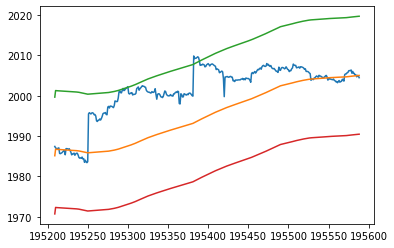

In [256]:
ax = prices_filtered[194970:195350].plot()
twap_1h_geo[194970:195350].plot(ax=ax)
twap_1h_geo_ask[194970:195350].plot(ax=ax)
twap_1h_geo_bid[194970:195350].plot(ax=ax)

In [257]:
print("prices_filtered", prices_filtered[195012:195013])
print("twap_1h_geo", twap_1h_geo[195012:195013])
print("twap_1h_geo_ask", twap_1h_geo_ask[195012:195013])
print("twap_1h_geo_bid", twap_1h_geo_bid[195012:195013])

prices_filtered 195251    1995.482323
Name: sim-53, dtype: float64
twap_1h_geo 195251    1985.863894
Name: sim-53, dtype: float64
twap_1h_geo_ask 195251    2000.380559
Name: sim-53, dtype: float64
twap_1h_geo_bid 195251    1971.452575
Name: sim-53, dtype: float64


In [258]:
1985.863894 * np.exp(SPREAD_X)

2000.38055906514

In [259]:
np.exp(SPREAD_X)

1.00731

In [260]:
0.00731 * 1985.863894

14.51666506514

# Compare the Ask value given to longs at time of jump with the TWAP value 1h into the future (used for unwind). Did the trader exit profitably while taking advantage of lag?

In [261]:
# prices at jump
print("prices_filtered at jump", prices_filtered[195012:195013])
print("twap_1h_geo at jump", twap_1h_geo[195012:195013])
print("twap_1h_geo_ask at jump", twap_1h_geo_ask[195012:195013])
print("twap_1h_geo_bid at jump", twap_1h_geo_bid[195012:195013])

prices_filtered at jump 195251    1995.482323
Name: sim-53, dtype: float64
twap_1h_geo at jump 195251    1985.863894
Name: sim-53, dtype: float64
twap_1h_geo_ask at jump 195251    2000.380559
Name: sim-53, dtype: float64
twap_1h_geo_bid at jump 195251    1971.452575
Name: sim-53, dtype: float64


In [262]:
195012 + 240

195252

In [263]:
# prices 1h after jump
print("prices_filtered 1h after jump", prices_filtered[195252:195253])
print("twap_1h_geo 1h after jump", twap_1h_geo[195252:195253])
print("twap_1h_geo_ask 1h after jump", twap_1h_geo_ask[195252:195253])
print("twap_1h_geo_bid 1h after jump", twap_1h_geo_bid[195252:195253])

prices_filtered 1h after jump 195491    2006.807187
Name: sim-53, dtype: float64
twap_1h_geo 1h after jump 195491    2002.48363
Name: sim-53, dtype: float64
twap_1h_geo_ask 1h after jump 195491    2017.121785
Name: sim-53, dtype: float64
twap_1h_geo_bid 1h after jump 195491    1987.951703
Name: sim-53, dtype: float64


In [264]:
# unwind price 1h after jump
twap_1h_geo[195252:195253]

195491    2002.48363
Name: sim-53, dtype: float64

In [265]:
# build price for long at jump (ask)
twap_1h_geo_ask[195012:195013]

195251    2000.380559
Name: sim-53, dtype: float64

In [266]:
# So profit on spread ...
(2002.48363 - 2000.380559) / 2000.380559

0.001051335452415782

# Profit on spread from time lag is about 0.1% which will get eaten by trading fees => 2 trades at 0.075% = .15%, so the time lag trade strategy is no longer profitable on this jump

# The jump here had a size of: 0.6% within a block

In [267]:
prices_filtered[195012:195013]

195251    1995.482323
Name: sim-53, dtype: float64

In [268]:
prices_filtered[195011:195012]

195250    1983.653382
Name: sim-53, dtype: float64

In [269]:
(1995.482323 - 1983.653382) / 1983.653382

0.005963209655143262

# Let's zoom out and look at bands over entire sim

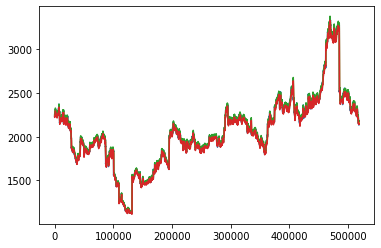

In [270]:
ax = prices_filtered.plot()
twap_1h_geo.plot(ax=ax)
twap_1h_geo_ask.plot(ax=ax)
twap_1h_geo_bid.plot(ax=ax)

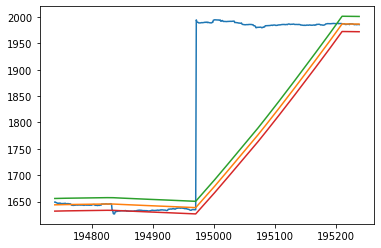

In [271]:
# Fine, but hard to see anything. Let's look at super extreme jump from 194500:195000
ax = prices_filtered[194500:195000].plot()
twap_1h_geo[194500:195000].plot(ax=ax)
twap_1h_geo_ask[194500:195000].plot(ax=ax)
twap_1h_geo_bid[194500:195000].plot(ax=ax)

# That's not good. Might want to instead have bands wrt to spot price? and only adjust up/down for side (long/short) where it's not favorable. can see issues with a massive drop ...

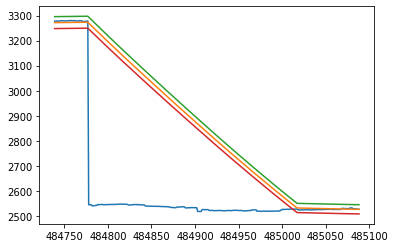

In [272]:
ax = prices_filtered[484500:484850].plot()
twap_1h_geo[484500:484850].plot(ax=ax)
twap_1h_geo_ask[484500:484850].plot(ax=ax)
twap_1h_geo_bid[484500:484850].plot(ax=ax)

# Let's look at some "relatively" normal behavior first before modifying spread function

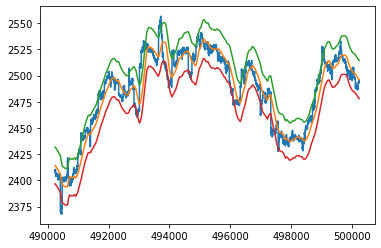

In [273]:
ax = prices_filtered[490000:500000].plot()
twap_1h_geo[490000:500000].plot(ax=ax)
twap_1h_geo_ask[490000:500000].plot(ax=ax)
twap_1h_geo_bid[490000:500000].plot(ax=ax)

# Not terrible. But ok, let's time shift the unwind TWAP 1h values 240 periods into the future and compare delta with build bid/ask prices, to plot how often timelag trade could be profitable

In [274]:
twap_1h_geo_1h_later = twap_1h_geo
twap_1h_geo_1h_later = twap_1h_geo_1h_later.shift(periods=-window_1h)
twap_1h_geo_1h_later

239       2257.076730
240       2257.226299
241       2257.378152
242       2257.527796
243       2257.678313
             ...     
518396            NaN
518397            NaN
518398            NaN
518399            NaN
518400            NaN
Name: sim-53, Length: 518162, dtype: float64

In [275]:
print(twap_1h_geo_1h_later[235:255])
print(twap_1h_geo_1h_later[len(twap_1h_geo_1h_later)-20-240:])

474    2279.186915
475    2279.215207
476    2279.234399
477    2279.251989
478    2279.269450
479    2279.286772
480    2279.307510
481    2279.323526
482    2279.341764
483    2279.359216
484    2279.380665
485    2279.404962
486    2279.428198
487    2279.453057
488    2279.478101
489    2279.502033
490    2279.526524
491    2279.551823
492    2279.576712
493    2279.598607
Name: sim-53, dtype: float64
518141    2160.249051
518142    2160.303117
518143    2160.356821
518144    2160.415235
518145    2160.473985
             ...     
518396            NaN
518397            NaN
518398            NaN
518399            NaN
518400            NaN
Name: sim-53, Length: 260, dtype: float64


# Now plot value of TWAP 1h into the future vs bands at current time

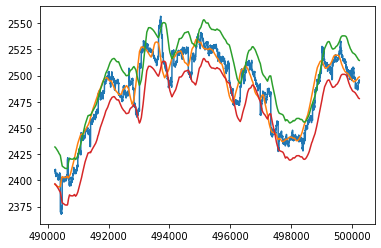

In [276]:
ax = prices_filtered[490000:500000].plot()
twap_1h_geo_1h_later[490000:500000].plot(ax=ax)
twap_1h_geo_ask[490000:500000].plot(ax=ax)
twap_1h_geo_bid[490000:500000].plot(ax=ax)

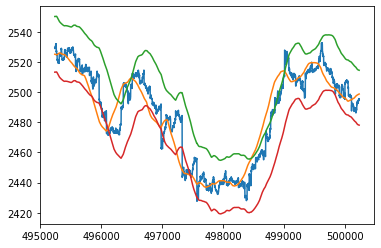

In [277]:
# zoom in ...
ax = prices_filtered[495000:500000].plot()
twap_1h_geo_1h_later[495000:500000].plot(ax=ax)
twap_1h_geo_ask[495000:500000].plot(ax=ax)
twap_1h_geo_bid[495000:500000].plot(ax=ax)

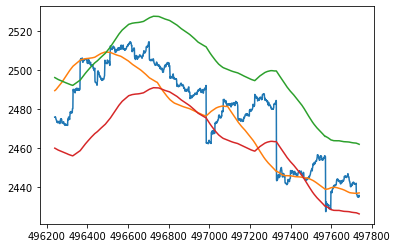

In [278]:
ax = prices_filtered[496000:497500].plot()
twap_1h_geo_1h_later[496000:497500].plot(ax=ax)
twap_1h_geo_ask[496000:497500].plot(ax=ax)
twap_1h_geo_bid[496000:497500].plot(ax=ax)

# There are select few cases where unwind value ends up being outside the bands in "normal" trading, although trading fees would take entire profit away.

# We want to prevent even the most insane jumps from printing. Use delta bw TWAP and spot. So what if we instead have:

## dB = max((spot-TWAP) * e^{ (1/T) * [E_B ] }, 0); dB is buy (long) spread
## dS = max((TWAP-spot) * e^{ (1/T) * [E_S ] }, 0); dS is sell (short) spread

In [279]:
dB = (prices_filtered*np.exp(SPREAD_X) - twap_1h_geo)
dB = dB.apply(lambda x: max(x, 0))
dB

239       15.090909
240       15.692410
241       15.866312
242       15.673407
243       15.527638
            ...    
518396    33.829128
518397    34.629117
518398    34.423515
518399    34.234038
518400    34.398050
Name: sim-53, Length: 518162, dtype: float64

In [280]:
dS = (twap_1h_geo - prices_filtered*np.exp(-SPREAD_X))
dS = dS.apply(lambda x: max(x, 0))
dS

239       17.504433
240       16.911550
241       16.740085
242       16.930051
243       17.073695
            ...    
518396     0.000000
518397     0.000000
518398     0.000000
518399     0.000000
518400     0.000000
Name: sim-53, Length: 518162, dtype: float64

In [281]:
twap_1h_geo_ask_spot_spread = twap_1h_geo + dB
twap_1h_geo_bid_spot_spread = twap_1h_geo - dS
print('twap_1h_geo_ask_spot_spread:', twap_1h_geo_ask_spot_spread)
print('twap_1h_geo_bid_spot_spread:', twap_1h_geo_bid_spot_spread)

twap_1h_geo_ask_spot_spread: 239       2253.979768
240       2254.575620
241       2254.744165
242       2254.540946
243       2254.394050
             ...     
518396    2195.094579
518397    2195.973470
518398    2195.846640
518399    2195.732025
518400    2195.970603
Name: sim-53, Length: 518162, dtype: float64
twap_1h_geo_bid_spot_spread: 239       2221.384426
240       2221.971661
241       2222.137768
242       2221.937489
243       2221.792717
             ...     
518396    2161.265451
518397    2161.344353
518398    2161.423125
518399    2161.497987
518400    2161.572553
Name: sim-53, Length: 518162, dtype: float64


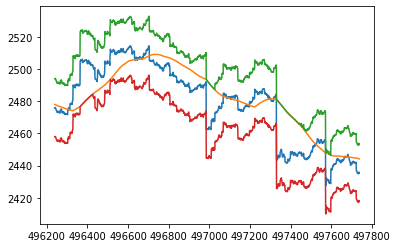

In [282]:
ax = prices_filtered[496000:497500].plot()
twap_1h_geo[496000:497500].plot(ax=ax)
twap_1h_geo_ask_spot_spread[496000:497500].plot(ax=ax)
twap_1h_geo_bid_spot_spread[496000:497500].plot(ax=ax)

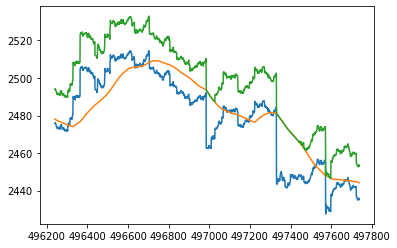

In [283]:
ax = prices_filtered[496000:497500].plot()
twap_1h_geo[496000:497500].plot(ax=ax)
twap_1h_geo_ask_spot_spread[496000:497500].plot(ax=ax)

# Ok, interesting .... will always stop at the TWAP. This isn't great. What we want is essentially the old band value to always be there. HOWEVER, when have a spike down (up), buy (sell) price stays the same BUT sell (buy) price spikes down to accomodate. So skews.

## Basically should reduce to:

## Ask: P_{t} = TWAP when TWAP > spot and = spot when TWAP < spot
## Bid: P_{t} = TWAP when TWAP < spot and = spot when TWAP > spot

## such that ...

## Ask = P_{t} * e^{E_S}
## Bid = P_{t} * e^{-E_S}

## where E_S is the spread to make it harder to make money in short term before funding kicks in -- harder to front run for users that have more info than us

In [284]:
twap_1h_geo_ask_skew = pd.concat([prices_filtered, twap_1h_geo], axis=1).max(axis=1) * np.exp(SPREAD_X)
twap_1h_geo_bid_skew = pd.concat([prices_filtered, twap_1h_geo], axis=1).min(axis=1) * np.exp(-SPREAD_X)

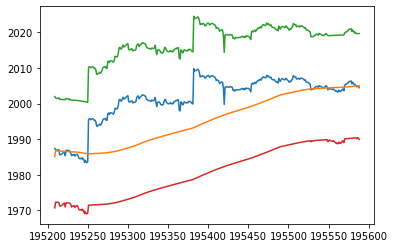

In [285]:
# Go back to the original jump ...
ax = prices_filtered[194970:195350].plot()
twap_1h_geo[194970:195350].plot(ax=ax)
twap_1h_geo_ask_skew[194970:195350].plot(ax=ax)
twap_1h_geo_bid_skew[194970:195350].plot(ax=ax)

# But isn't this susceptible to attack through manipulating the spot? Maybe?

# Let's look back at the most extreme jumps ...

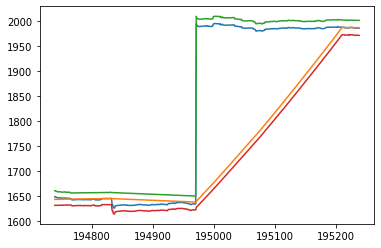

In [286]:
# Fine, but hard to see anything. Let's look at super extreme jump from 194500:195000
ax = prices_filtered[194500:195000].plot()
twap_1h_geo[194500:195000].plot(ax=ax)
twap_1h_geo_ask_skew[194500:195000].plot(ax=ax)
twap_1h_geo_bid_skew[194500:195000].plot(ax=ax)

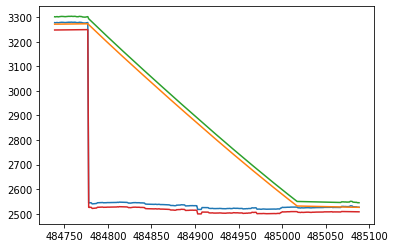

In [287]:
ax = prices_filtered[484500:484850].plot()
twap_1h_geo[484500:484850].plot(ax=ax)
twap_1h_geo_ask_skew[484500:484850].plot(ax=ax)
twap_1h_geo_bid_skew[484500:484850].plot(ax=ax)

# Definitively eliminates any chance of profit on the lag trade from the long ... but shorts will want to wait an hour for catch up in order to place next bet since they know they'll lose if they enter into a trade here.

# Problem then occurs for longs exiting? Since they get the red line but know they should wait to exit? But everyone has info spot jumped and so it's not us getting milked necessarily since they fairly made money

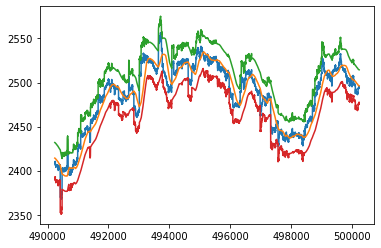

In [288]:
ax = prices_filtered[490000:500000].plot()
twap_1h_geo[490000:500000].plot(ax=ax)
twap_1h_geo_ask_skew[490000:500000].plot(ax=ax)
twap_1h_geo_bid_skew[490000:500000].plot(ax=ax)

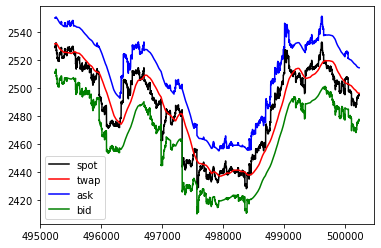

In [289]:
# zoom in ...
ax = prices_filtered[495000:500000].plot(c='k', label='spot')
twap_1h_geo[495000:500000].plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew[495000:500000].plot(ax=ax, c='b', label='ask')
twap_1h_geo_bid_skew[495000:500000].plot(ax=ax, c='g', label='bid')
ax.legend()

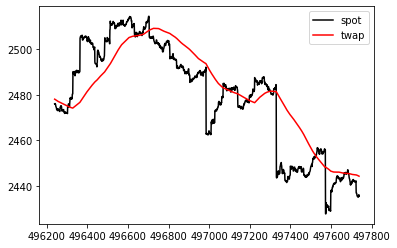

In [290]:
ax = prices_filtered[496000:497500].plot(c='k', label='spot')
twap_1h_geo[496000:497500].plot(ax=ax, c='r', label='twap')
ax.legend()

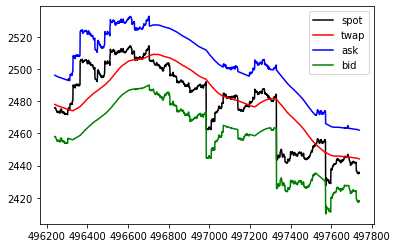

In [291]:
ax = prices_filtered[496000:497500].plot(c='k', label='spot')
twap_1h_geo[496000:497500].plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew[496000:497500].plot(ax=ax, c='b', label='ask')
twap_1h_geo_bid_skew[496000:497500].plot(ax=ax, c='g', label='bid')

ax.legend()
ax.get_figure().savefig('png/sim_twap_lag_spread_vol.png')

In [292]:
print('spot entry', prices_filtered[496527-window_1h:496527-window_1h+5])
print('twap entry', twap_1h_geo[496527-window_1h:496527-window_1h+5])
print('ask entry', twap_1h_geo_ask_skew[496527-window_1h:496527-window_1h+5])
print('bid entry', twap_1h_geo_bid_skew[496527-window_1h:496527-window_1h+5])

spot entry 496526    2512.126386
496527    2512.234513
496528    2512.194264
496529    2511.817816
496530    2511.283742
Name: sim-53, dtype: float64
twap entry 496526    2495.687773
496527    2495.854993
496528    2496.023623
496529    2496.188664
496530    2496.350400
Name: sim-53, dtype: float64
ask entry 496526    2530.490030
496527    2530.598947
496528    2530.558404
496529    2530.179204
496530    2529.641226
dtype: float64
bid entry 496526    2477.576687
496527    2477.742694
496528    2477.910101
496529    2478.073944
496530    2478.234505
dtype: float64


In [293]:
print('spot exit', prices_filtered[497499:497501])
print('twap exit', twap_1h_geo[497499:497501])
print('ask exit', twap_1h_geo_ask_skew[497499:497501])
print('bid exit', twap_1h_geo_bid_skew[497499:497501])

spot exit 497738    2435.347407
497739    2435.633881
Name: sim-53, dtype: float64
twap exit 497738    2444.175897
497739    2444.125453
Name: sim-53, dtype: float64
ask exit 497738    2462.042823
497739    2461.992010
dtype: float64
bid exit 497738    2417.674208
497739    2417.958603
dtype: float64


In [294]:
print('delta spot', (2512.234513-2435.633881)/2512.234513)
print('delta twap', (2496.023623-2444.125453)/2496.023623)
print('delta short [-(ask-bid)/bid]', -(2461.992010-2477.910101)/2477.910101)

delta spot 0.030491035611371557
delta twap 0.020792339271862706
delta short [-(ask-bid)/bid] 0.006423998592029632


# Back to the original, less extreme jump plot w bid/ask spread...

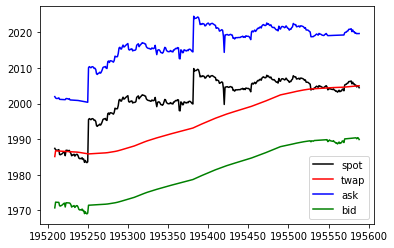

In [295]:
ax = prices_filtered[194970:195350].plot(c='k', label='spot')
twap_1h_geo[194970:195350].plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew[194970:195350].plot(ax=ax, c='b', label='ask')
twap_1h_geo_bid_skew[194970:195350].plot(ax=ax, c='g', label='bid')

ax.legend()
ax.get_figure().savefig('png/sim_twap_lag_spread.png')

In [296]:
print('spot at jump', prices_filtered[195010:195015])
print('twap at jump', twap_1h_geo[195010:195015])
print('ask at jump', twap_1h_geo_ask_skew[195010:195015])
print('bid at jump', twap_1h_geo_bid_skew[195010:195015])

spot at jump 195249    1983.410406
195250    1983.653382
195251    1995.482323
195252    1995.783461
195253    1995.607815
Name: sim-53, dtype: float64
twap at jump 195249    1985.893596
195250    1985.848948
195251    1985.863894
195252    1985.880668
195253    1985.891454
Name: sim-53, dtype: float64
ask at jump 195249    2000.410478
195250    2000.365504
195251    2010.069299
195252    2010.372638
195253    2010.195708
dtype: float64
bid at jump 195249    1969.016893
195250    1969.258105
195251    1971.452575
195252    1971.469228
195253    1971.479936
dtype: float64


In [297]:
print('spot 1h after jump', prices_filtered[195010+window_1h:195015+window_1h])
print('twap 1h after jump', twap_1h_geo[195010+window_1h:195015+window_1h])
print('ask 1h after jump', twap_1h_geo_ask_skew[195010+window_1h:195015+window_1h])
print('bid 1h after jump', twap_1h_geo_bid_skew[195010+window_1h:195015+window_1h])

spot 1h after jump 195489    2006.375940
195490    2006.265032
195491    2006.807187
195492    2006.988585
195493    2006.943630
Name: sim-53, dtype: float64
twap 1h after jump 195489    2002.341845
195490    2002.436412
195491    2002.483630
195492    2002.530344
195493    2002.577607
Name: sim-53, dtype: float64
ask 1h after jump 195489    2021.042548
195490    2020.930829
195491    2021.476948
195492    2021.659672
195493    2021.614387
dtype: float64
bid 1h after jump 195489    1987.810947
195490    1987.904828
195491    1987.951703
195492    1987.998078
195493    1988.044998
dtype: float64


# And for entire span of timeseries data ...

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


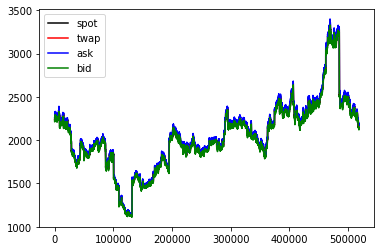

In [298]:
ax = prices_filtered.plot(c='k', label='spot')
twap_1h_geo.plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew.plot(ax=ax, c='b', label='ask')
twap_1h_geo_bid_skew.plot(ax=ax, c='g', label='bid')

ax.legend()
ax.get_figure().savefig('png/sim_twap_lag_spread_all.png')

In [299]:
# 3 months of data ...
500000*15.0/86400.0

86.80555555555556

# Ok. Seems to be handling jumps nicely. Now, let's look at profitability of the long lag trade by examining ask price (long's build price) vs bid price 1h into the future (long's unwind price)

In [300]:
twap_1h_geo_ask_skew_1h_later = twap_1h_geo_ask_skew.shift(periods=-window_1h)
twap_1h_geo_bid_skew_1h_later = twap_1h_geo_bid_skew.shift(periods=-window_1h)

In [301]:
print(twap_1h_geo_ask_skew[240:260])
print(twap_1h_geo_ask_skew_1h_later[:20])

479    2291.640118
480    2290.717823
481    2291.442954
482    2290.696155
483    2290.756926
484    2290.702931
485    2290.418495
486    2290.858042
487    2290.854230
488    2290.786291
489    2291.108474
490    2290.913732
491    2290.807520
492    2290.883919
493    2290.909398
494    2290.396761
495    2290.415955
496    2293.653069
497    2293.466396
498    2293.740934
dtype: float64
239    2291.640118
240    2290.717823
241    2291.442954
242    2290.696155
243    2290.756926
244    2290.702931
245    2290.418495
246    2290.858042
247    2290.854230
248    2290.786291
249    2291.108474
250    2290.913732
251    2290.807520
252    2290.883919
253    2290.909398
254    2290.396761
255    2290.415955
256    2293.653069
257    2293.466396
258    2293.740934
dtype: float64


In [302]:
# Look at long scalp lag trade PnL. Compare the ask (long's build price) with the time-shifted bid (long's unwind price)
dp_long_scalp_skew = twap_1h_geo_bid_skew_1h_later / twap_1h_geo_ask_skew - 1
dp_long_scalp_skew[:100]

239   -0.006455
240   -0.006387
241   -0.006318
242   -0.006247
243   -0.006180
         ...   
334   -0.009292
335   -0.008935
336   -0.009247
337   -0.009473
338   -0.009414
Length: 100, dtype: float64

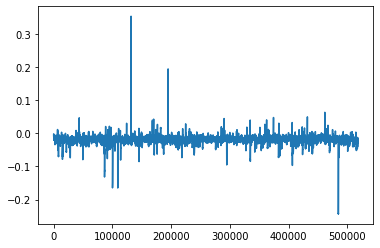

In [303]:
dp_long_scalp_skew.plot()

# Hmm how is there a positive 0.3 price delta? Zoom in ...

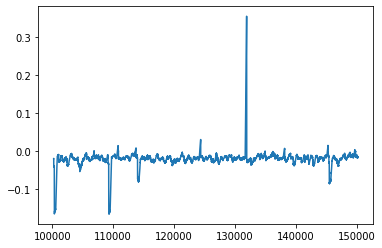

In [304]:
dp_long_scalp_skew[100000:150000].plot()

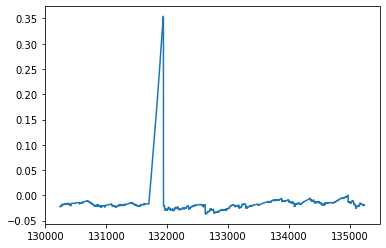

In [305]:
dp_long_scalp_skew[130000:135000].plot()

# Looks weird. Examine price data around there ...

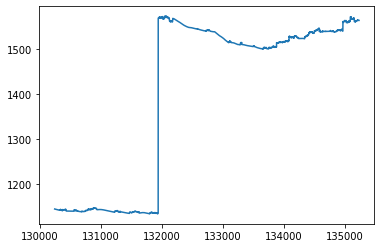

In [306]:
twap_1h_geo_ask_skew[130000:135000].plot()

# Oh, it's my time shift? Since user got in RIGHT before jump. so of course they'll make money. Check to be sure

In [307]:
print(twap_1h_geo_ask_skew[131700:131702])

131939    1137.090463
131940    1569.021661
dtype: float64


In [308]:
dp_long_scalp_skew[131700:131702]

131939    0.353228
131940   -0.019422
dtype: float64

# Ok good. Confirmed - only made money by getting in BEFORE jump occurs. After jump occurs, 1h scalp is no longer profitable. Still issues with manipulation, but this requires knowing price will jump. Either have to manipulate the price to do this (COA analysis) or have info on jump prior to it happening.

## Do we want market impact fees to prevent the latter?

# Check from plot with bands ...

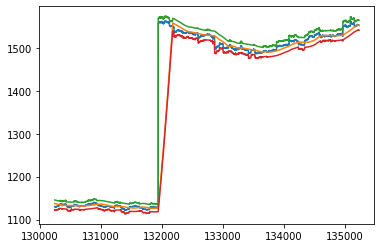

In [309]:
ax = prices_filtered[130000:135000].plot()
twap_1h_geo[130000:135000].plot(ax=ax)
twap_1h_geo_ask_skew[130000:135000].plot(ax=ax)
twap_1h_geo_bid_skew[130000:135000].plot(ax=ax)

# Zoom in ...

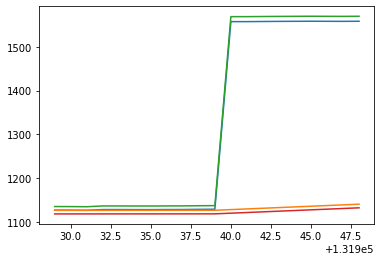

In [310]:
ax = prices_filtered[131690:131710].plot()
twap_1h_geo[131690:131710].plot(ax=ax)
twap_1h_geo_ask_skew[131690:131710].plot(ax=ax)
twap_1h_geo_bid_skew[131690:131710].plot(ax=ax)

In [311]:
# entry price still higher at moment of jump
(1569.021661 - 1137.090463) / 1137.090463

0.37985649519953807

# Look at long entry price (ask) vs long exit price (bid 1h later) on the jump up in price

## => Will only be profitable if user enters long trade BEFORE jump. Ask > bid+1h after jump

### ... suggests need to be manipulating spot OR trader knows jump is coming

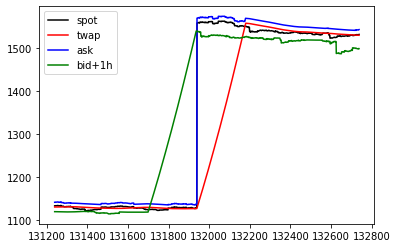

In [312]:
ax = prices_filtered[131000:132500].plot(c='k', label='spot')
twap_1h_geo[131000:132500].plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew[131000:132500].plot(ax=ax, c='b', label='ask')
twap_1h_geo_bid_skew_1h_later[131000:132500].plot(ax=ax, c='g', label='bid+1h')
ax.legend()

# Look at short entry price (bid) vs short exit price (ask 1h later) on the jump up in price

## => Will never be profitable. Ask+1h > bid

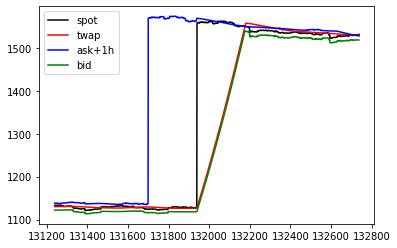

In [313]:
ax = prices_filtered[131000:132500].plot(c='k', label='spot')
twap_1h_geo[131000:132500].plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew_1h_later[131000:132500].plot(ax=ax, c='b', label='ask+1h')
twap_1h_geo_bid_skew[131000:132500].plot(ax=ax, c='g', label='bid')
ax.legend()

# What's the average of the pnl on the trade. Careful here since not normally distributed so sample mean, sample variance aren't good to use

In [314]:
dp_long_scalp_skew_sample_mean = dp_long_scalp_skew.sum() / len(dp_long_scalp_skew)
dp_long_scalp_skew_sample_variance = ((dp_long_scalp_skew - dp_long_scalp_skew_sample_mean)**2).sum() / len(dp_long_scalp_skew)
print('sample mean', dp_long_scalp_skew_sample_mean)
print('sample variance', dp_long_scalp_skew_sample_variance)

sample mean -0.018517701378862626
sample variance 0.00018433876776685732


# And for the short lag trade?

In [315]:
# Look at short scalp lag trade PnL. Compare the bid (short's build price) with the time-shifted ask (short's unwind price)
dp_short_scalp_skew = 1 - twap_1h_geo_ask_skew_1h_later / twap_1h_geo_bid_skew
dp_short_scalp_skew[:100]

239   -0.031627
240   -0.030939
241   -0.031189
242   -0.030945
243   -0.031040
         ...   
334   -0.030714
335   -0.030692
336   -0.030492
337   -0.030547
338   -0.030697
Length: 100, dtype: float64

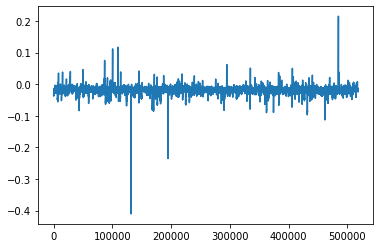

In [316]:
dp_short_scalp_skew.plot()

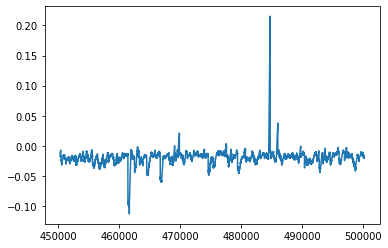

In [317]:
dp_short_scalp_skew[450000:500000].plot()

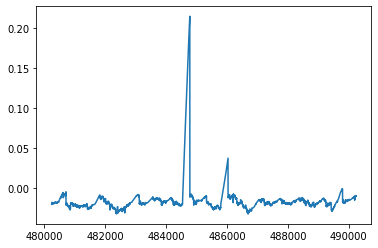

In [318]:
dp_short_scalp_skew[480000:490000].plot()

# Make sure short trade with 20% pnl needs to be entered into BEFORE jump occurred

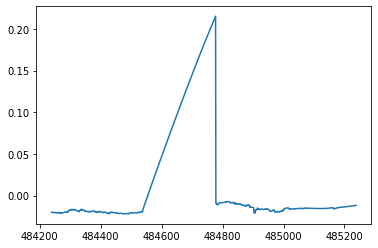

In [319]:
dp_short_scalp_skew[484000:485000].plot()

In [320]:
dp_short_scalp_skew[484000:485000]

484239   -0.019961
484240   -0.020155
484241   -0.019958
484242   -0.020133
484243   -0.020069
            ...   
485234   -0.011973
485235   -0.011927
485236   -0.011877
485237   -0.011826
485238   -0.011781
Length: 1000, dtype: float64

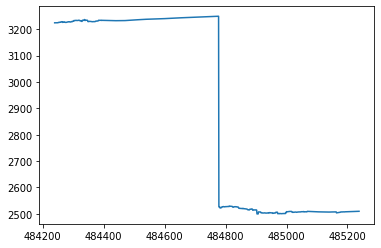

In [321]:
twap_1h_geo_bid_skew[484000:485000].plot()

In [322]:
print(twap_1h_geo_bid_skew[484538:484540])

484777    3249.480660
484778    2526.076849
dtype: float64


In [323]:
-(2526.076849 - 3249.480660) / 3249.480660

0.22262136220869216

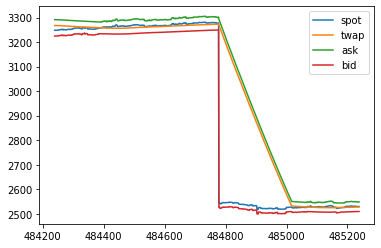

In [324]:
ax = prices_filtered[484000:485000].plot(label='spot')
twap_1h_geo[484000:485000].plot(ax=ax, label='twap')
twap_1h_geo_ask_skew[484000:485000].plot(ax=ax, label='ask')
twap_1h_geo_bid_skew[484000:485000].plot(ax=ax, label='bid')
ax.legend()

In [325]:
dp_short_scalp_skew_sample_mean = dp_short_scalp_skew.sum() / len(dp_short_scalp_skew)
dp_short_scalp_skew_sample_variance = ((dp_short_scalp_skew - dp_short_scalp_skew_sample_mean)**2).sum() / len(dp_short_scalp_skew)
print('sample mean', dp_short_scalp_skew_sample_mean)
print('sample variance', dp_short_scalp_skew_sample_variance)

sample mean -0.01903631428800741
sample variance 0.0002384172226334628


# OK. Bid adjusts properly. Looks good for short trade.

# Look at long entry price (ask) vs long exit price (bid 1h later) on the jump down in price

## => Will never be profitable. ask > bid+1h

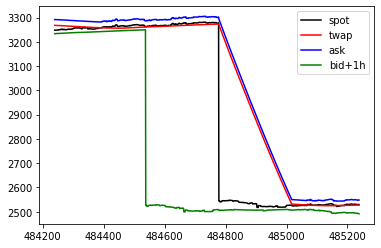

In [326]:
ax = prices_filtered[484000:485000].plot(c='k', label='spot')
twap_1h_geo[484000:485000].plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew[484000:485000].plot(ax=ax, c='b', label='ask')
twap_1h_geo_bid_skew_1h_later[484000:485000].plot(ax=ax, c='g', label='bid+1h')
ax.legend()

# Look at short entry price (bid) vs short exit price (ask 1h later) on the jump up in price

## => Will only be profitable if user enters short trade BEFORE jump. Ask+1h > bid after jump

### ... suggests need to be manipulating spot OR trader knows jump is coming

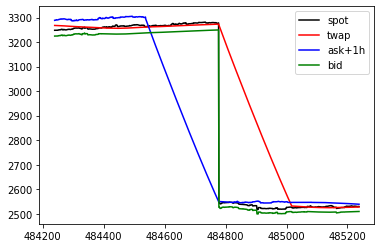

In [327]:
ax = prices_filtered[484000:485000].plot(c='k', label='spot')
twap_1h_geo[484000:485000].plot(ax=ax, c='r', label='twap')
twap_1h_geo_ask_skew_1h_later[484000:485000].plot(ax=ax, c='b', label='ask+1h')
twap_1h_geo_bid_skew[484000:485000].plot(ax=ax, c='g', label='bid')
ax.legend()

# What about if we compare with the non-skewed approach?

## As in, where diff with spot isn't accounted for and we just have bands

In [328]:
twap_1h_geo_ask_1h_later = twap_1h_geo_ask.shift(periods=-window_1h)
twap_1h_geo_bid_1h_later = twap_1h_geo_bid.shift(periods=-window_1h)

In [329]:
print(twap_1h_geo_ask[240:260])
print(twap_1h_geo_ask_1h_later[:20])

479    2273.575961
480    2273.726623
481    2273.879586
482    2274.030324
483    2274.181942
484    2274.343914
485    2274.506417
486    2274.687491
487    2274.869002
488    2275.051531
489    2275.231639
490    2275.411111
491    2275.590810
492    2275.769565
493    2275.948084
494    2276.126046
495    2276.303252
496    2276.498537
497    2276.693118
498    2276.888693
Name: sim-53, dtype: float64
239    2273.575961
240    2273.726623
241    2273.879586
242    2274.030324
243    2274.181942
244    2274.343914
245    2274.506417
246    2274.687491
247    2274.869002
248    2275.051531
249    2275.231639
250    2275.411111
251    2275.590810
252    2275.769565
253    2275.948084
254    2276.126046
255    2276.303252
256    2276.498537
257    2276.693118
258    2276.888693
Name: sim-53, dtype: float64


In [330]:
dp_long_scalp = twap_1h_geo_bid_1h_later / twap_1h_geo_ask - 1
dp_long_scalp

239      -0.006455
240      -0.006387
241      -0.006318
242      -0.006247
243      -0.006180
            ...   
518396         NaN
518397         NaN
518398         NaN
518399         NaN
518400         NaN
Name: sim-53, Length: 518162, dtype: float64

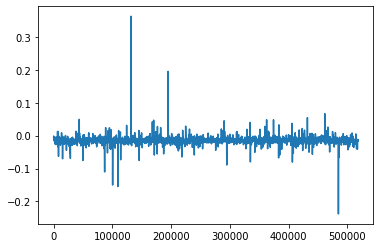

In [331]:
dp_long_scalp.plot()

In [332]:
dp_long_scalp_sample_mean = dp_long_scalp.sum() / len(dp_long_scalp)
dp_long_scalp_sample_variance = ((dp_long_scalp - dp_long_scalp_sample_mean)**2).sum() / len(dp_long_scalp)
print('sample mean', dp_long_scalp_sample_mean)
print('sample variance', dp_long_scalp_sample_variance)

sample mean -0.014388536605569505
sample variance 0.0001691201138230575


# Still not bad actually. But in reality would likely be worse given smart traders

# Test against adam's bump up, which seems to mimic a spot manipulation.

# Two cases to consider:

## 1. I enter a long w max leverage and increase spot price significantly over a few blocks

## 2. I manipulate spot price up over a few blocks and enter a short at the top

## In either case, can I EXIT with substantial profit after a few blocks << avg window?

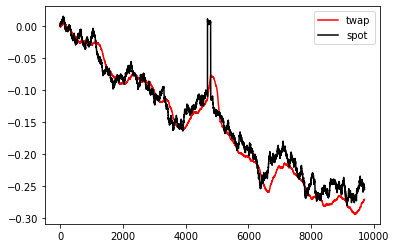

In [333]:
plt.plot(twap_crets, c='r', label='twap')
plt.plot(crets, c='k', label='spot')
plt.legend()

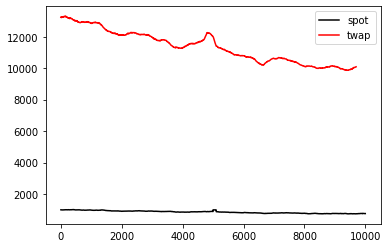

In [334]:
plt.plot(prices_w_shock, c='k', label='spot')
plt.plot(Shock_twaps, c='r', label='twap')
plt.legend()

# Recalculate TWAP here from prices_w_shock since something's up w scale on Adam's TWAP

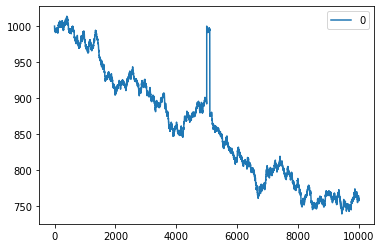

In [335]:
df_prices_w_shock = pd.DataFrame(data=prices_w_shock)
df_prices_w_shock.plot(label='spot')

In [336]:
window_50 = 50
window_150 = 150
window_240 = 240

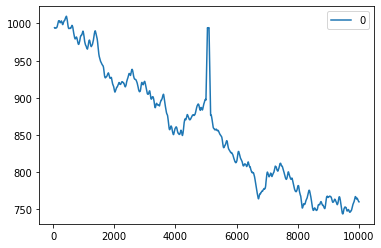

In [337]:
df_twap_50_geo_w_shock = df_prices_w_shock.rolling(window=window_50).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_50), raw=True)
df_twap_50_geo_w_shock = df_twap_50_geo_w_shock[~df_twap_50_geo_w_shock.isnull()]
df_twap_50_geo_w_shock.plot()

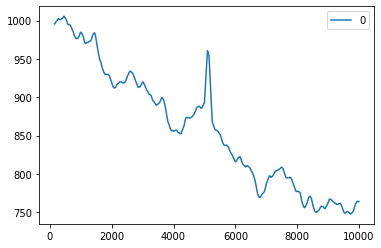

In [338]:
df_twap_150_geo_w_shock = df_prices_w_shock.rolling(window=window_150).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_150), raw=True)
df_twap_150_geo_w_shock = df_twap_150_geo_w_shock[~df_twap_150_geo_w_shock.isnull()]
df_twap_150_geo_w_shock.plot()

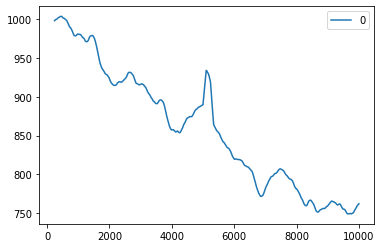

In [339]:
df_twap_240_geo_w_shock = df_prices_w_shock.rolling(window=window_240).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_240), raw=True)
df_twap_240_geo_w_shock = df_twap_240_geo_w_shock[~df_twap_240_geo_w_shock.isnull()]
df_twap_240_geo_w_shock.plot()

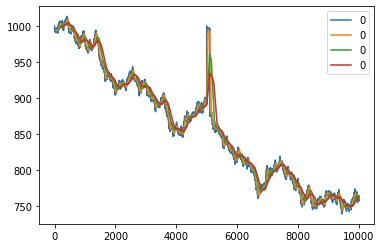

In [340]:
ax = df_prices_w_shock.plot(label='spot')
df_twap_50_geo_w_shock.plot(ax=ax, label='twap-50')
df_twap_150_geo_w_shock.plot(ax=ax, label='twap-150')
df_twap_240_geo_w_shock.plot(ax=ax, label='twap-240')
ax.legend()

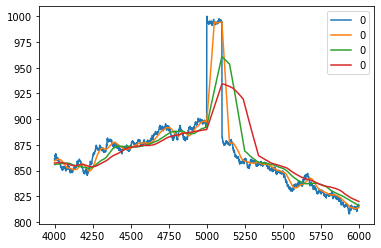

In [341]:
ax = df_prices_w_shock[4000:6000].plot(label='spot')
df_twap_50_geo_w_shock[4000:6000].plot(ax=ax, label='twap-50')
df_twap_150_geo_w_shock[4000:6000].plot(ax=ax, label='twap-150')
df_twap_240_geo_w_shock[4000:6000].plot(ax=ax, label='twap-240')
ax.legend()

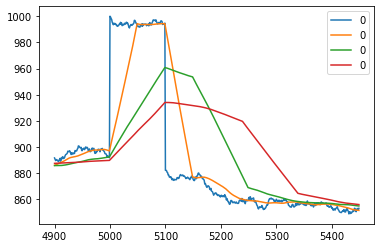

In [342]:
shock_time = 5000
ax = df_prices_w_shock[shock_time-100:shock_time+450].plot(label='spot')
df_twap_50_geo_w_shock[shock_time-100:shock_time+450].plot(ax=ax, label='twap-50')
df_twap_150_geo_w_shock[shock_time-100:shock_time+450].plot(ax=ax, label='twap-150')
df_twap_240_geo_w_shock[shock_time-100:shock_time+450].plot(ax=ax, label='twap-240')
ax.legend()

# Analyze the most extreme lag case with window of 240 ...

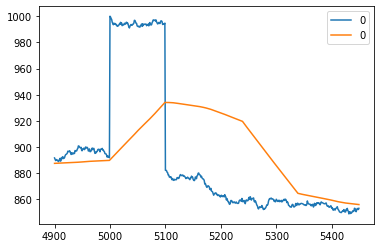

In [343]:
ax = df_prices_w_shock[shock_time-100:shock_time+450].plot(label='spot')
df_twap_240_geo_w_shock[shock_time-100:shock_time+450].plot(ax=ax, label='twap-240')
ax.legend()

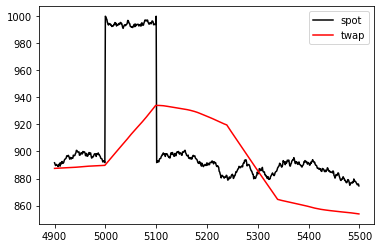

In [397]:
plt.plot(df_prices_w_shock[shock_time-100:shock_time+500], c='k', label='spot')
plt.plot(df_twap_240_geo_w_shock[shock_time-100:shock_time+500], c='r', label='twap')

plt.legend()
plt.savefig('png/sim_twap_attack.png')

# Calculate the bid/ask with spread using skew formula:

## Ask: P_{t} = TWAP when TWAP > spot and = spot when TWAP < spot
## Bid: P_{t} = TWAP when TWAP < spot and = spot when TWAP > spot

## such that ...

## Ask = P_{t} * e^{E_S}
## Bid = P_{t} * e^{-E_S}

In [344]:
df_twap_240_geo_w_shock_ask_skew = pd.concat([df_prices_w_shock, df_twap_240_geo_w_shock], axis=1).max(axis=1) * np.exp(SPREAD_X)
df_twap_240_geo_w_shock_bid_skew = pd.concat([df_prices_w_shock, df_twap_240_geo_w_shock], axis=1).min(axis=1) * np.exp(-SPREAD_X)

In [345]:
SPREAD_X

0.007283411446258746

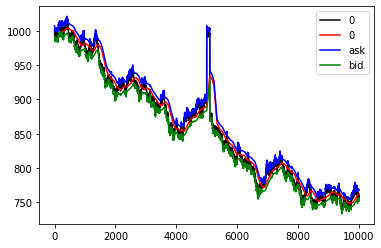

In [346]:
ax = df_prices_w_shock.plot(c='k', label='spot')
df_twap_240_geo_w_shock.plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_shock_ask_skew.plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_shock_bid_skew.plot(ax=ax, c='g', label='bid')
ax.legend()

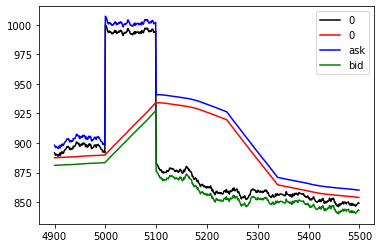

In [347]:
ax = df_prices_w_shock[shock_time-100:shock_time+500].plot(c='k', label='spot')
df_twap_240_geo_w_shock[shock_time-100:shock_time+500].plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_shock_ask_skew[shock_time-100:shock_time+500].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_shock_bid_skew[shock_time-100:shock_time+500].plot(ax=ax, c='g', label='bid')
ax.legend()

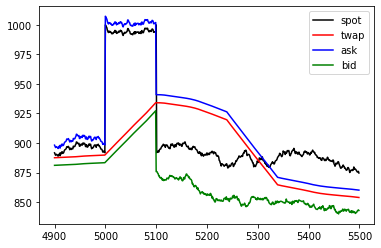

In [396]:
plt.plot(df_prices_w_shock[shock_time-100:shock_time+500], c='k', label='spot')
plt.plot(df_twap_240_geo_w_shock[shock_time-100:shock_time+500], c='r', label='twap')
plt.plot(df_twap_240_geo_w_shock_ask_skew[shock_time-100:shock_time+500], c='b', label='ask')
plt.plot(df_twap_240_geo_w_shock_bid_skew[shock_time-100:shock_time+500], c='g', label='bid')

plt.legend()
plt.savefig('png/sim_twap_attack_spread.png')

# Ask -- Entry price for longs, Exit price for shorts
# Bid -- Entry price for shorts, Exit price for longs

# Analyze PnL if I do attack trades 1. & 2. above over 240 block window.

## Do this by looking at PnL of long and of short trade (similar to before with mc sim path), exiting after 1h in trade

## 1. long: entry at ask, exit at bid
## 2. short: entry at bid, exit at ask

In [348]:
df_twap_240_geo_w_shock_ask_skew_1h_later = df_twap_240_geo_w_shock_ask_skew.shift(periods=-window_240)
df_twap_240_geo_w_shock_bid_skew_1h_later = df_twap_240_geo_w_shock_bid_skew.shift(periods=-window_240)

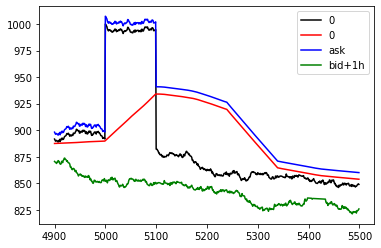

In [349]:
# trade 1 (long): ... yes it looks impossible to profit since blue > green_1h_later for entire graph
ax = df_prices_w_shock[shock_time-100:shock_time+500].plot(c='k', label='spot')
df_twap_240_geo_w_shock[shock_time-100:shock_time+500].plot(ax=ax, c='r', label='twap-240')
df_twap_240_geo_w_shock_ask_skew[shock_time-100:shock_time+500].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_shock_bid_skew_1h_later[shock_time-100:shock_time+500].plot(ax=ax, c='g', label='bid+1h')
ax.legend()

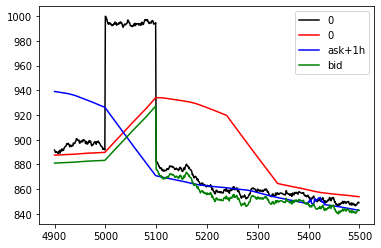

In [350]:
# trade 2 (short): After halfway through the spot manipulation, if I enter into a short, I would have made ~ 4% profit ... due to drift down after?
ax = df_prices_w_shock[shock_time-100:shock_time+500].plot(c='k', label='spot')
df_twap_240_geo_w_shock[shock_time-100:shock_time+500].plot(ax=ax, c='r', label='twap-240')
df_twap_240_geo_w_shock_ask_skew_1h_later[shock_time-100:shock_time+500].plot(ax=ax, c='b', label='ask+1h')
df_twap_240_geo_w_shock_bid_skew[shock_time-100:shock_time+500].plot(ax=ax, c='g', label='bid')
ax.legend()

# With trade 2 here I made 4% from shorting immediately after spike back down. Cost to produce spike on spot for 20M pool is about 50M.

# Cost of attack including capital to overcome 50M sunk cost with offered max leverage of 5x is 50M/0.2 = 250M

## Is this 4% profit simply due to drift down after? or is it an attack?

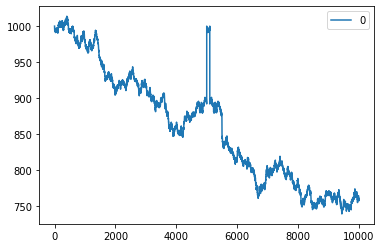

In [351]:
prices_w_shock_and_plateau = df_prices_w_shock[0].to_numpy()
prices_w_shock_and_plateau
for i in range(400):
    prices_w_shock_and_plateau[shock_block + 100 + i] = prices_w_shock_and_plateau[shock_block - i]

df_prices_w_shock_and_plateau = pd.DataFrame(data=prices_w_shock_and_plateau)    
df_prices_w_shock_and_plateau.plot()

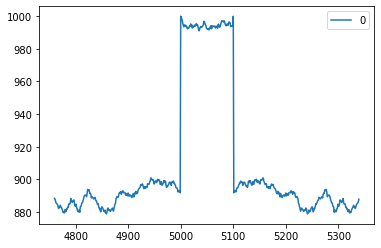

In [352]:
df_prices_w_shock_and_plateau[shock_block-240:shock_block+100+240].plot()

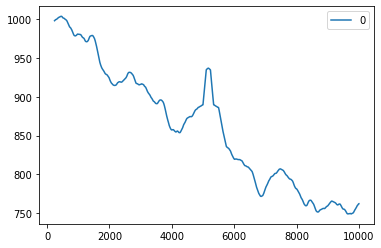

In [353]:
df_twap_240_geo_w_shock_and_plateau = df_prices_w_shock_and_plateau.rolling(window=window_240).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_240), raw=True)
df_twap_240_geo_w_shock_and_plateau = df_twap_240_geo_w_shock_and_plateau[~df_twap_240_geo_w_shock_and_plateau.isnull()]
df_twap_240_geo_w_shock_and_plateau.plot()

In [354]:
df_twap_240_geo_w_shock_and_plateau_ask_skew = pd.concat([df_prices_w_shock_and_plateau, df_twap_240_geo_w_shock_and_plateau], axis=1).max(axis=1) * np.exp(SPREAD_X)
df_twap_240_geo_w_shock_and_plateau_bid_skew = pd.concat([df_prices_w_shock_and_plateau, df_twap_240_geo_w_shock_and_plateau], axis=1).min(axis=1) * np.exp(-SPREAD_X)

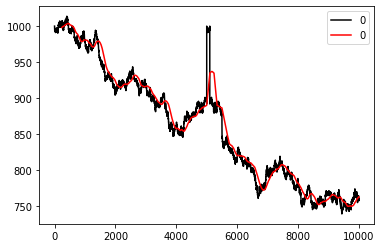

In [355]:
ax = df_prices_w_shock_and_plateau.plot(c='k', label='spot')
df_twap_240_geo_w_shock_and_plateau.plot(ax=ax, c='r', label='twap')
ax.legend()

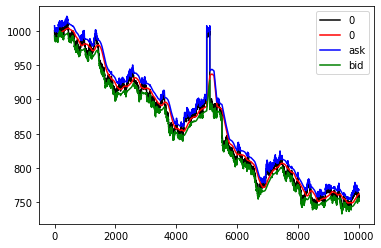

In [356]:
ax = df_prices_w_shock_and_plateau.plot(c='k', label='spot')
df_twap_240_geo_w_shock_and_plateau.plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_shock_and_plateau_ask_skew.plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_shock_and_plateau_bid_skew.plot(ax=ax, c='g', label='bid')
ax.legend()

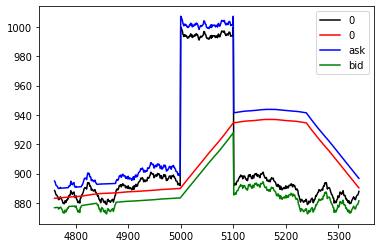

In [357]:
# zoom in
ax = df_prices_w_shock_and_plateau[shock_block-240:shock_block+100+240].plot(c='k', label='spot')
df_twap_240_geo_w_shock_and_plateau[shock_block-240:shock_block+100+240].plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_shock_and_plateau_ask_skew[shock_block-240:shock_block+100+240].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_shock_and_plateau_bid_skew[shock_block-240:shock_block+100+240].plot(ax=ax, c='g', label='bid')
ax.legend()

In [358]:
# timeshift bid/ask values to check pnl ...
df_twap_240_geo_w_shock_and_plateau_ask_skew_1h_later = df_twap_240_geo_w_shock_and_plateau_ask_skew.shift(periods=-window_240)
df_twap_240_geo_w_shock_and_plateau_bid_skew_1h_later = df_twap_240_geo_w_shock_and_plateau_bid_skew.shift(periods=-window_240)

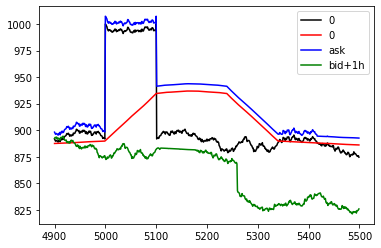

In [359]:
# trade 1 (long): ... yes still looks impossible to profit
ax = df_prices_w_shock_and_plateau[shock_time-100:shock_time+500].plot(c='k', label='spot')
df_twap_240_geo_w_shock_and_plateau[shock_time-100:shock_time+500].plot(ax=ax, c='r', label='twap-240')
df_twap_240_geo_w_shock_and_plateau_ask_skew[shock_time-100:shock_time+500].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_shock_and_plateau_bid_skew_1h_later[shock_time-100:shock_time+500].plot(ax=ax, c='g', label='bid+1h')
ax.legend()

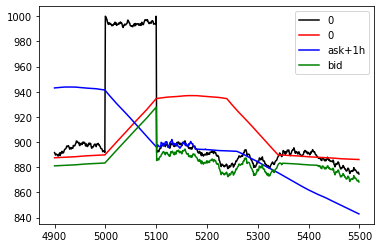

In [360]:
# trade 2 (short): Still ... After halfway through the spot manipulation, if I enter into a short, I would have made ~ 4% profit ... due to drift down after?
ax = df_prices_w_shock_and_plateau[shock_time-100:shock_time+500].plot(c='k', label='spot')
df_twap_240_geo_w_shock_and_plateau[shock_time-100:shock_time+500].plot(ax=ax, c='r', label='twap-240')
df_twap_240_geo_w_shock_and_plateau_ask_skew_1h_later[shock_time-100:shock_time+500].plot(ax=ax, c='b', label='ask+1h')
df_twap_240_geo_w_shock_and_plateau_bid_skew[shock_time-100:shock_time+500].plot(ax=ax, c='g', label='bid')
ax.legend()

In [361]:
# PnL is about 3.30% profit
print('bid', df_twap_240_geo_w_shock_and_plateau_bid_skew[shock_time+99])
print('ask (1h later)', df_twap_240_geo_w_shock_and_plateau_ask_skew_1h_later[shock_time+99])
print('pnl', -(df_twap_240_geo_w_shock_and_plateau_ask_skew_1h_later[shock_time+99] - df_twap_240_geo_w_shock_and_plateau_bid_skew[shock_time+99]) / df_twap_240_geo_w_shock_and_plateau_bid_skew[shock_time+99])

bid 927.2804917837719
ask (1h later) 896.7052258818936
pnl 0.032973049873034545


In [362]:
print('cost of manipulation on $20M spot pool with max 5x leverage for 100 block 12% jump (in $M):', 100*(20/2)*(1000.0-891.77)/891.77)
print('cost of attack on $20M spot pool with max 5x leverage for 100 block 12% jump (in $M):', 100*(20/2)*(np.sqrt(1+(1000.0-891.77)/891.77)-1) * (1 + 1/(0.033*5.0)))

cost of manipulation on $20M spot pool with max 5x leverage for 100 block 12% jump (in $M): 121.36537447996683
cost of attack on $20M spot pool with max 5x leverage for 100 block 12% jump (in $M): 416.1902961540871


# Price delta short gets from manipulating the spot then shorting right before stop manipulation is about 3.3% here. To do this profitably, costs upfront about 400M in this example.

# What if shock only happens over e.g. 10 blocks? ... goes from 50M to 5M to manip spot. 

In [363]:
df_prices_w_shock_and_plateau[shock_time-1: shock_time+1]

,0
4999,891.770167
5000,1000.000000


In [364]:
print((1000.0-891.77)/891.77)

0.12136537447996683


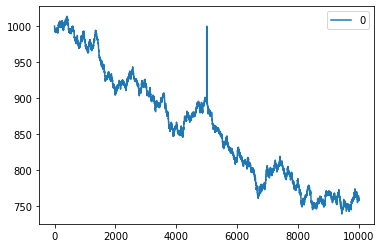

In [365]:
prices_w_short_shock = m.prices.copy()
shock_block = 5000
# 10 blocks is about 2-2.5 min
for i in range(10):
    prices_w_short_shock[shock_block + i] = prices_w_short_shock[i]
df_prices_w_short_shock = pd.DataFrame(data=prices_w_short_shock)    
df_prices_w_short_shock.plot()

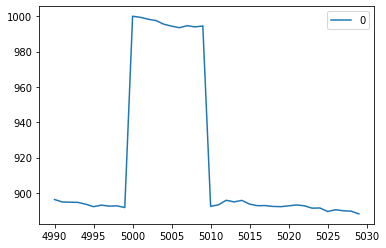

In [366]:
df_prices_w_short_shock[shock_block-10:shock_block+30].plot()

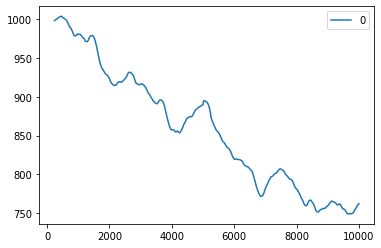

In [367]:
df_twap_240_geo_w_short_shock = df_prices_w_short_shock.rolling(window=window_240).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_240), raw=True)
df_twap_240_geo_w_short_shock = df_twap_240_geo_w_short_shock[~df_twap_240_geo_w_short_shock.isnull()]
df_twap_240_geo_w_short_shock.plot()

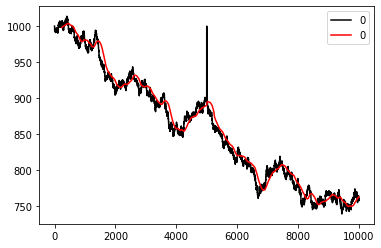

In [368]:
ax = df_prices_w_short_shock.plot(c='k', label='spot')
df_twap_240_geo_w_short_shock.plot(ax=ax, c='r', label='twap')
ax.legend()

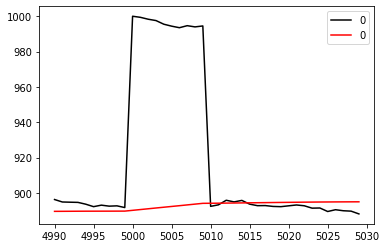

In [369]:
ax = df_prices_w_short_shock[shock_block-10:shock_block+30].plot(c='k', label='spot')
df_twap_240_geo_w_short_shock[shock_block-10:shock_block+30].plot(ax=ax, c='r', label='twap')
ax.legend()

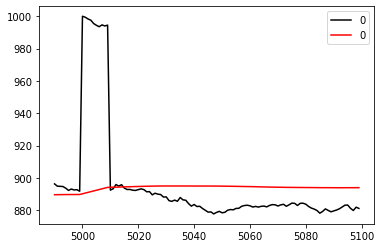

In [370]:
ax = df_prices_w_short_shock[shock_block-10:shock_block+100].plot(c='k', label='spot')
df_twap_240_geo_w_short_shock[shock_block-10:shock_block+100].plot(ax=ax, c='r', label='twap')
ax.legend()

In [371]:
df_twap_240_geo_w_short_shock_ask_skew = pd.concat([df_prices_w_short_shock, df_twap_240_geo_w_short_shock], axis=1).max(axis=1) * np.exp(SPREAD_X)
df_twap_240_geo_w_short_shock_bid_skew = pd.concat([df_prices_w_short_shock, df_twap_240_geo_w_short_shock], axis=1).min(axis=1) * np.exp(-SPREAD_X)

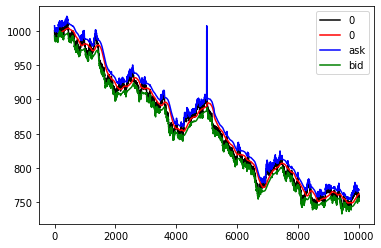

In [372]:
ax = df_prices_w_short_shock.plot(c='k', label='spot')
df_twap_240_geo_w_short_shock.plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_short_shock_ask_skew.plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_short_shock_bid_skew.plot(ax=ax, c='g', label='bid')
ax.legend()

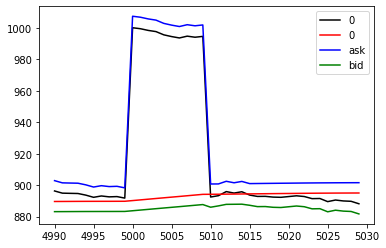

In [373]:
# zoom in
ax = df_prices_w_short_shock[shock_block-10:shock_block+30].plot(c='k', label='spot')
df_twap_240_geo_w_short_shock[shock_block-10:shock_block+30].plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_short_shock_ask_skew[shock_block-10:shock_block+30].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_short_shock_bid_skew[shock_block-10:shock_block+30].plot(ax=ax, c='g', label='bid')
ax.legend()

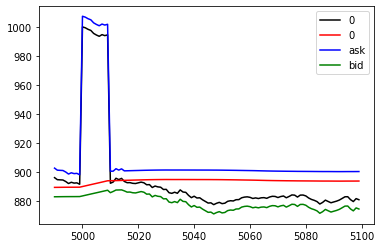

In [374]:
ax = df_prices_w_short_shock[shock_block-10:shock_block+100].plot(c='k', label='spot')
df_twap_240_geo_w_short_shock[shock_block-10:shock_block+100].plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_short_shock_ask_skew[shock_block-10:shock_block+100].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_short_shock_bid_skew[shock_block-10:shock_block+100].plot(ax=ax, c='g', label='bid')
ax.legend()

# Timelag to check whether the short leg of the trade on shorter spot manip is still profitable

In [375]:
df_twap_240_geo_w_short_shock_ask_skew_1h_later = df_twap_240_geo_w_short_shock_ask_skew.shift(periods=-window_240)
df_twap_240_geo_w_short_shock_bid_skew_1h_later = df_twap_240_geo_w_short_shock_bid_skew.shift(periods=-window_240)

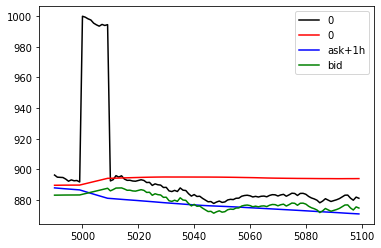

In [376]:
ax = df_prices_w_short_shock[shock_time-10:shock_time+100].plot(c='k', label='spot')
df_twap_240_geo_w_short_shock[shock_time-10:shock_time+100].plot(ax=ax, c='r', label='twap-240')
df_twap_240_geo_w_short_shock_ask_skew_1h_later[shock_time-10:shock_time+100].plot(ax=ax, c='b', label='ask+1h')
df_twap_240_geo_w_short_shock_bid_skew[shock_time-10:shock_time+100].plot(ax=ax, c='g', label='bid')
ax.legend()

# PnL for scalp over shorter duration of 2.5min is only about 0.74%. Likely not worth it...

In [377]:
print('bid (short entry)', df_twap_240_geo_w_short_shock_bid_skew[shock_time+10-1])
print('ask+1h (short exit)', df_twap_240_geo_w_short_shock_ask_skew_1h_later[shock_time+10-1])
print('pnl (short 1h scalp)', -(df_twap_240_geo_w_short_shock_ask_skew_1h_later[shock_time+10-1] - df_twap_240_geo_w_short_shock_bid_skew[shock_time+10-1])/df_twap_240_geo_w_short_shock_bid_skew[shock_time+10-1])

bid (short entry) 887.6672804778636
ask+1h (short exit) 881.1339052055963
pnl (short 1h scalp) 0.007360162322024736


In [378]:
print('cost of manipulation on $20M spot pool with max 5x leverage for 10 block 12% jump (in $M):', 10*(20/2)*(np.sqrt(1+(1000.0-891.77)/891.77)-1))
print('cost of attack on $20M spot pool with max 5x leverage for 10 block 12% jump (in $M):', 10*(20/2)*(np.sqrt(1+(1000.0-891.77)/891.77)-1) * (1 + 1/(0.0074*5.0)))

cost of manipulation on $20M spot pool with max 5x leverage for 10 block 12% jump (in $M): 5.894540675143722
cost of attack on $20M spot pool with max 5x leverage for 10 block 12% jump (in $M): 165.20645081416322


# Still requires ~ 165M for PnL > 0 with attack. And 160M of it is attempting to go into the Overlay market.

# So this appears robust. Falls under original cost of attack on TWAP analysis of note 2

# Try a short LARGE shock to be safe ...

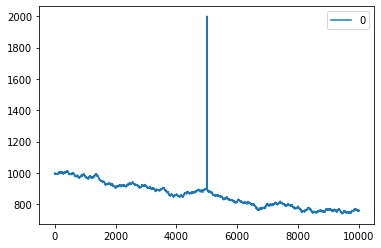

In [379]:
prices_w_short_large_shock = m.prices.copy()
shock_block = 5000
# 10 blocks is about 2-2.5 min
for i in range(10):
    prices_w_short_large_shock[shock_block + i] = prices_w_short_large_shock[i]*2
df_prices_w_short_large_shock = pd.DataFrame(data=prices_w_short_large_shock)    
df_prices_w_short_large_shock.plot()

In [380]:
# cost to manipulate spot 2x over 10 blocks w 20M pool is about $40M 
10*10*(np.sqrt(1+1)-1)

41.42135623730952

In [381]:
df_twap_240_geo_w_short_large_shock = df_prices_w_short_large_shock.rolling(window=window_240).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_240), raw=True)
df_twap_240_geo_w_short_large_shock_ask_skew = pd.concat([df_prices_w_short_large_shock, df_twap_240_geo_w_short_large_shock], axis=1).max(axis=1) * np.exp(SPREAD_X)
df_twap_240_geo_w_short_large_shock_bid_skew = pd.concat([df_prices_w_short_large_shock, df_twap_240_geo_w_short_large_shock], axis=1).min(axis=1) * np.exp(-SPREAD_X)

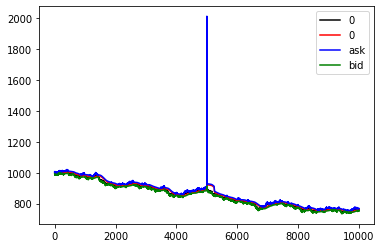

In [382]:
ax = df_prices_w_short_large_shock.plot(c='k', label='spot')
df_twap_240_geo_w_short_large_shock.plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_short_large_shock_ask_skew.plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_short_large_shock_bid_skew.plot(ax=ax, c='g', label='bid')
ax.legend()

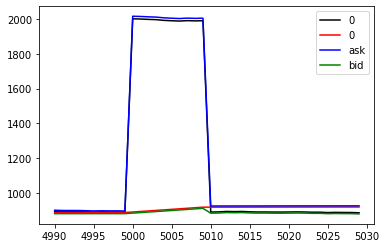

In [383]:
ax = df_prices_w_short_large_shock[shock_time-10:shock_time+30].plot(c='k', label='spot')
df_twap_240_geo_w_short_large_shock[shock_time-10:shock_time+30].plot(ax=ax, c='r', label='twap')
df_twap_240_geo_w_short_large_shock_ask_skew[shock_time-10:shock_time+30].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_short_large_shock_bid_skew[shock_time-10:shock_time+30].plot(ax=ax, c='g', label='bid')
ax.legend()

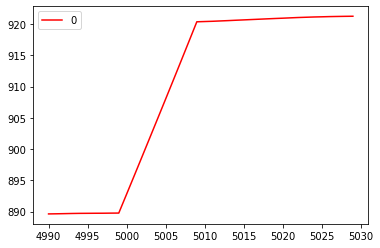

In [384]:
df_twap_240_geo_w_short_large_shock[shock_time-10:shock_time+30].plot(c='r', label='twap')

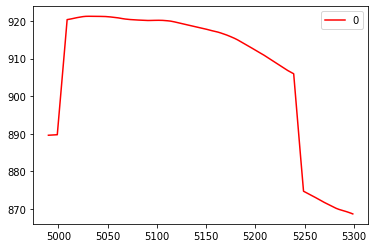

In [385]:
df_twap_240_geo_w_short_large_shock[shock_time-10:shock_time+300].plot(c='r', label='twap')

In [386]:
df_twap_240_geo_w_short_large_shock_ask_skew_1h_later = df_twap_240_geo_w_short_large_shock_ask_skew.shift(periods=-window_240)
df_twap_240_geo_w_short_large_shock_bid_skew_1h_later = df_twap_240_geo_w_short_large_shock_bid_skew.shift(periods=-window_240)

# And what about the trades? on the long side => zero profit again ...

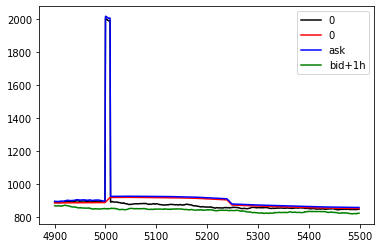

In [387]:
# trade 1 (long): ... yes still looks impossible to profit
ax = df_prices_w_short_large_shock[shock_time-100:shock_time+500].plot(c='k', label='spot')
df_twap_240_geo_w_short_large_shock[shock_time-100:shock_time+500].plot(ax=ax, c='r', label='twap-240')
df_twap_240_geo_w_short_large_shock_ask_skew[shock_time-100:shock_time+500].plot(ax=ax, c='b', label='ask')
df_twap_240_geo_w_short_large_shock_bid_skew_1h_later[shock_time-100:shock_time+500].plot(ax=ax, c='g', label='bid+1h')
ax.legend()

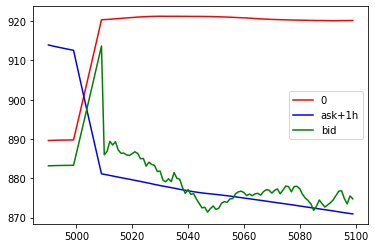

In [388]:
# trade 2 (short): After halfway through the spot manipulation, if I enter into a short, I would have made ~ 4% profit ... due to drift down after?
ax = df_twap_240_geo_w_short_large_shock[shock_time-10:shock_time+100].plot(c='r', label='twap-240')
df_twap_240_geo_w_short_large_shock_ask_skew_1h_later[shock_time-10:shock_time+100].plot(ax=ax, c='b', label='ask+1h')
df_twap_240_geo_w_short_large_shock_bid_skew[shock_time-10:shock_time+100].plot(ax=ax, c='g', label='bid')
ax.legend()

In [389]:
print('bid (short entry)', df_twap_240_geo_w_short_large_shock_bid_skew[shock_time+10-1])
print('ask+1h (short exit)', df_twap_240_geo_w_short_large_shock_ask_skew_1h_later[shock_time+10-1])
print('pnl (short)', -(df_twap_240_geo_w_short_large_shock_ask_skew_1h_later[shock_time+10-1]-df_twap_240_geo_w_short_large_shock_bid_skew[shock_time+10-1])/df_twap_240_geo_w_short_large_shock_bid_skew[shock_time+10-1])

bid (short entry) 913.677917191111
ask+1h (short exit) 881.1339052055963
pnl (short) 0.0356186916343164


In [390]:
print('spot start', df_prices_w_short_large_shock[shock_time-1:shock_time])
print('spot jumps to', df_prices_w_short_large_shock[shock_time:shock_time+1])
print('price change', (2000.0-891.770167)/891.770167)

spot start                0
4999  891.770167
spot jumps to            0
5000  2000.0
price change 1.242730328968271


# 3.56% profit is large and similar to longer attack (100 blocks). This attack is 124.27% jump in price over 10 blocks

## But costs 330M to execute if want PnL > 0. So we're good

In [391]:
print('cost of manipulation on $20M spot pool with max 5x leverage for 10 block 125% jump (in $M):', 10*(20/2)*(np.sqrt(1+(2000.0-891.77)/891.77)-1))
print('cost of attack on $20M spot pool with max 5x leverage for 10 block 125% jump (in $M):', 10*(20/2)*(np.sqrt(1+(2000.0-891.77)/891.77)-1) * (1 + 1/(0.0356*5.0)))

cost of manipulation on $20M spot pool with max 5x leverage for 10 block 125% jump (in $M): 49.757495604057624
cost of attack on $20M spot pool with max 5x leverage for 10 block 125% jump (in $M): 329.2939877616847


# Look at the long side of the spot manipulation scenario. I know the spike is coming because I'm paying to manipulate spot, and I go long on Overlay before manipulating.

# How much can I make? Because the ask is close to the TWAP before BUT the bid is the TWAP at the end of the attack, cost of attack (COA) analysis from note 2 applies here